In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as scs
from sklearn.preprocessing import normalize as norm
from sklearn import linear_model
import datetime
import time
from datetime import datetime , timedelta

import zipfile
import math

from csv import reader
from matplotlib.pyplot import figure
import seaborn as sns;
import re


In [2]:
list_of_companies_number = ['1080', '1113', '1221', '1229', '1243', '1388', '1431', '1472', '1694', '1769', '1865', '1907', '1956', '2028',
                           '2050', '2051', '2057', '2094', '2197', '2290', '2368', '2645', '2651', '2730', '2748', '2813', '2822', '2890', 
                           '3022', '3035', '3107', '3161', '3388', '3459', '3757', '3879', '4060', '4154', '4218', '4320', '4481', 
                            '4549', '4575', '4618', '4695', '4736', '4799', '4851', '5836', '7843', '7858', '8080', '9034', '9058', '9061',
                           '9062', '9063', '9064', '9065', '9067', '9069', '9074', '9086', '9094', '9265', '9266', '9268', '9269',
                            '9270', '9761', '10166', '10470', '10484', '10508', '10795', '10887', '11038', '11234', '11244', '11390', '11399',
                           '11583','11618','11714', '11867', '11869', '11946', '12059', '12098', '12255', '12327', '12417', '12456', '12534',
                           '12552', '12713', '13003', '13061', '13113']

In [3]:
#shape = [(nr of company, every possible timeslot from 8.00 till 16.29, bid/ask, price/volume, 5 best offers from 9.15!))]
data = np.zeros(shape = (100, 5100,2,2,5)) 

In [4]:
def get_k_best_offers(record, k=5):
    count = 0
    count_bid = 0
    count_ask = 0
    k_best_bids_and_asks = np.zeros(shape = (2,2,k))
    while(record[count]!='ASK'):
        count+=1
    for counter in range(1,k*2 + 1):
        #bid
        if record[count-counter]=='BID':
            continue
        k_best_bids_and_asks[0][counter%2][(counter-1)//2]=record[count-counter]
        #ask
        k_best_bids_and_asks[1][(counter-1)%2][(counter-1)//2]=record[count+counter]
        
    return k_best_bids_and_asks

In [5]:
def get_mid_price(record): #shape = (2,2,5) (bid/ask, price/volume, best offers):
    return (record[1][0][0]+record[0][0][0])/2

In [6]:
def get_true_price(record): # Qa*Pb/(Qa+Qb) + Qb*Pa/(Qa+Qb)
    Qa=record[1][1][0] #ask quantity
    Qb=record[0][1][0] #bid quantity
    Q=Qa+Qb
    Pa=record[1][0][0] #ask price
    Pb=record[0][0][0] #bid price
    return Qa*Pb/(Q+1e-10) + Qb*Pa/(Q+1e-10)

In [7]:
def get_sweep_to_fill_price(record, order_size, midprice, sweep_buys=False): #record.shape=(2,2,5)
    if sweep_buys:
        record=record[0] # sweep buys
    else:
        record=record[1] # sweep asks
    order_left = order_size
    counter=0
    weighted_price = 0
    while order_left>0:
        curr_vol = record[1][counter]
        curr_price = record[0][counter]
        if curr_vol >= order_left:
            weighted_price+=order_left*curr_price
            order_left =0
        else:
            weighted_price+=curr_vol*curr_price
            order_left-=curr_vol
        counter+=1
        if counter==5:
            print("Unable to fill an order", order_size)
            return midprice
    return weighted_price/order_size
    

In [8]:
def get_sweep_to_fill_price_raising_error(record, order_size, midprice, sweep_buys=False): #record.shape=(2,2,5)
    if record.shape!=(2,2,5):
        raise ValueError('Bad record shape!')
    if order_size==0:
        raise ValueError("Order size is 0")
    if sweep_buys:
        record=record[0] # sweep buys
    else:
        record=record[1] # sweep asks
    order_left = order_size
    counter=0
    weighted_price = 0
    while order_left>0:
        curr_vol = record[1][counter]
        curr_price = record[0][counter]
        if curr_vol >= order_left:
            weighted_price+=order_left*curr_price
            order_left =0
        else:
            weighted_price+=curr_vol*curr_price
            order_left-=curr_vol
        counter+=1
        if counter==5:
            raise ValueError("Unable to fill an order of size " + str(order_size))
    return weighted_price/order_size
    

In [9]:
#### PO co?
def apply_moving_average(record, num_of_days_prev):
    for i in range(num_of_days_prev, record.shape[0]):
        record[i] = np.sum(record[i-num_of_days_prev+1:i+1])/num_of_days_prev
    return record

In [71]:
def index_to_time(index):
    if index<0:
        raise ValueError("Index lower than 0!")
    hour=index//60
    minute=index%60
    return hour+8, minute, 0 
# why minute+1???? was because orderbook[0] was from 8:01
def time_tuple_to_hr_mn_str(time_tuple):
    if time_tuple[0]<10:
        hour='0'+str(time_tuple[0])
    else:
        hour=str(time_tuple[0])
    if time_tuple[1]<10:
        minute='0'+str(time_tuple[1])
    else:
        minute=str(time_tuple[1])
    return hour+':'+minute

In [11]:
### ADD valueerrors?

def get_true_price_after_sweep_to_fill(record, order_size, midprice):
    curr_record = record
    order_left = order_size
    counter=0
    while order_left>0:
        curr_vol = curr_record[1][1][counter]
        if curr_vol >= order_left:
            curr_record[1][1][counter]-=order_left
            order_left =0
            counter-=1
        else:
            curr_record[1][1][counter] = 0
            order_left-=curr_vol
        counter+=1
        if counter==5:
            print("Unable to fill an order", order_size)
            return midprice #???? bad?
    Qa=0 #ask quantity
    Qb=0 #bid quantity
    Pa=0 #ask price
    Pb=0 #bid price
    row_in_queue = 0
    while curr_record[1][1][row_in_queue]==0:
        row_in_queue+=1
    Qa=curr_record[1][1][row_in_queue]
    Pa=curr_record[1][0][row_in_queue]
    row_in_queue = 0
    while curr_record[0][1][row_in_queue]==0:
        row_in_queue+=1
    Qb=curr_record[0][1][row_in_queue] 
    Q=Qa+Qb 
    Pb=curr_record[0][0][row_in_queue] 
    return Qa*Pb/Q + Qb*Pa/Q

In [12]:
'''def get_order_inbalance(record): #single company
    
    timestamps=record.shape[0]
    result=np.zeros(timestamps)
    for i in range (0,timestamps):
        result[i]=math.log((1e-10+np.sum(record[i][0][1]))/(1e-10+np.sum(record[i][1][1]))) # ln(bid size/ask size)
    return result'''
#uhmmm wrong func???

'def get_order_inbalance(record): #single company\n    \n    timestamps=record.shape[0]\n    result=np.zeros(timestamps)\n    for i in range (0,timestamps):\n        result[i]=math.log((1e-10+np.sum(record[i][0][1]))/(1e-10+np.sum(record[i][1][1]))) # ln(bid size/ask size)\n    return result'

# READ DATA

In [166]:
# read order books into data
mom_count = 0
count_comp = -1
for num_comp in list_of_companies_number:
    with open('FTSE100\OrderBookSnapshots.csv.'+num_comp+'\OrderBookSnapshots.csv', 'r') as read_obj:
        csv_reader = reader(read_obj)
        count = 0
        count_comp+=1
        prev_hour = 8
        prev_date = '20130902'
        prev_min=0
        prev_elements = []
        for row in csv_reader:
            elements = row[0].split('\t')
            date_time = elements[0]
            date_holder, time_holder = date_time.split(' ')
            if date_holder != prev_date:
                prev_hour = 8
                prev_min=0
            cur_hour = int(time_holder[:2])
            cur_min = int(time_holder[2:4])
            if((cur_hour==8 and cur_min>=0) or (cur_hour>8 and cur_hour<16) or (cur_hour==16 and cur_min<30)):
                data[count_comp][count] = get_k_best_offers(elements[1:])  
                count+=1

In [14]:
# read trades into trades
days={
    2:0,
    3:1,
    4:2,
    5:3,
    6:4,
    9:5,
    10:6,
    11:7,
    12:8,
    13:9,
}
if_first_row = True
which_comp = 0

#comp = list_of_companies_number
comp = list_of_companies_number
comp_id = -1
trades = np.empty( shape=(len(comp), 10), dtype = list)
for i in range(trades.shape[0]):
    for j in range(10):
        trades[i,j]=list()
for num_comp in comp:
    comp_id+=1
    if_first_row = True
    with open('FTSE100trades\TradeDetailsExtract.'+num_comp+'.csv', 'r') as read_obj:
        csv_reader = reader(read_obj)
        for row in csv_reader:
            if if_first_row:
                if_first_row = False
                continue
            date = row[4]
            date_elem = date.split(" ")
            act_day = int(date_elem[0][8:10])
            time_tuple=time.strptime(date_elem[1], '%H:%M:%S')
            time_tuple=(time_tuple.tm_hour, time_tuple.tm_min, time_tuple.tm_sec)
          #  trades=np.append(trades, (row[2], row[3], time_tuple),  axis=1)
            #print("XD", comp_id, act_day, date_elem, row[2], row[3], time_tuple)
            try:
                trades[comp_id][days[act_day]].append((float(row[2]), int(row[3]), time_tuple)) # price, volume, timestamp
            except:
                print("Bad acting day or data, please check both\n", comp_id, act_day)
                print((row[2]), (row[3]), time_tuple)

Bad acting day or data, please check both
 1 30
854.5066 4596 (7, 5, 24)
Bad acting day or data, please check both
 1 8
900.0 4848 (0, 0, 0)
Bad acting day or data, please check both
 2 30
561.9 670 (9, 52, 54)
Bad acting day or data, please check both
 2 30
561.9 670 (9, 52, 54)
Bad acting day or data, please check both
 2 30
561.9 670 (9, 52, 54)
Bad acting day or data, please check both
 3 30
841.9143 11354 (7, 5, 24)
Bad acting day or data, please check both
 5 30
389.3276 3223 (7, 5, 24)
Bad acting day or data, please check both
 7 30
435.4457 4675 (7, 5, 24)
Bad acting day or data, please check both
 9 30
2146.5318 1115 (7, 5, 24)
Bad acting day or data, please check both
 12 30
290.7493 3328 (7, 5, 24)
Bad acting day or data, please check both
 13 30
120.01 100 (7, 5, 24)
Bad acting day or data, please check both
 16 30
1103.1111 414 (7, 5, 24)
Bad acting day or data, please check both
 17 30
1090.5 25000 (17, 37, 50)
Bad acting day or data, please check both
 20 30
761.5762 127

Bad acting day or data, please check both
 97 30
345.1342 1168 (7, 5, 24)
Bad acting day or data, please check both
 98 30
1596.4102 231 (7, 5, 24)


In [15]:
print(data.shape)
print(trades.shape)

(100, 5100, 2, 2, 5)
(99, 10)


# parameters calculation functions

In [16]:


def get_order_inbalance_interval(record, interval=1): #interval in minutes
    timestamps=record.shape[0]//interval
    result=np.zeros(timestamps)
    for i in range (0,timestamps):
        pom=i*interval
        result[i]=math.log((1e-10+np.sum(record[pom:pom+interval,0,1]))/(1e-10+np.sum(record[pom:pom+interval,1,1]))) # ln(bid size/ask size)
    return result

def get_order_inbalance_comp(comp_id=1, interval=1, time_to_skip=0): #interval in minutes
    order_inbalance_comp=np.empty(shape=(10,(510-time_to_skip)//interval))
    for i in range(10): #we have data from 10 days, 2 work weeks
        order_inbalance_comp[i]=get_order_inbalance_interval(data[comp_id, 510*i+time_to_skip:510*(i+1)], interval)
    return order_inbalance_comp

In [17]:
pom=data[3, 510:510*(2)]
pom[1:5,0,1]

array([[1504.,  466., 2115., 8682.,  667.],
       [3396.,  701., 2615., 8682.,  501.],
       [3582.,  701., 2115., 8682., 1001.],
       [3323., 3262., 3146., 9713., 2032.]])

In [18]:
get_order_inbalance_comp(interval=60, time_to_skip=30)[0]

array([ 0.07873018, -0.06199148,  0.19954649, -0.03546426,  0.01784012,
       -0.08710945, -0.2216419 , -0.25986639])

In [19]:
get_order_inbalance_comp(interval=60, time_to_skip=30)[0]

array([ 0.07873018, -0.06199148,  0.19954649, -0.03546426,  0.01784012,
       -0.08710945, -0.2216419 , -0.25986639])

In [68]:
def get_vwap_and_ordersizes_comp(comp_id=3, interval=5, time_to_skip=0, use_abs=True, max_vol=math.inf):
    order_book_comp=np.empty(shape=(10, 510-time_to_skip, 2, 2, 5))
    for i in range(10): #we have data from 10 days, 2 work weeks
        order_book_comp[i]=data[comp_id, 510*i+time_to_skip:510*(i+1)]

    trades_time_comp=np.copy(trades[comp_id])
    for day in trades_time_comp:
        day.sort(key=lambda hour: hour[2]) # sort by trade time

    timestamps=(510-time_to_skip)//interval
    # buys on even, sells on odd
    vwaps=np.zeros(shape=(10,2*timestamps)) 
    order_sizes=np.zeros(shape=(10,2*timestamps))
    #vwaps_sells=np.zeros(shape=(10,timestamps))
    empty_sells=0
    empty_buys=0
   # last_time=index_to_time(0)
    for day in range(vwaps.shape[0]):
        trade_counter=0
        skip_time_tuple=index_to_time(time_to_skip-interval)
        while skip_time_tuple>trades_time_comp[day][trade_counter][2]:
            trade_counter+=1
        for counter in range(timestamps):
            true_price=get_true_price(order_book_comp[day,counter])
            time_tuple=index_to_time(time_to_skip+interval*(counter))
            last_time=time_tuple
            buys=[]
            sells=[]
            buys_weights=[]
            sells_weights=[]
            while time_tuple>trades_time_comp[day][trade_counter][2]:
                if true_price<trades_time_comp[day][trade_counter][0]:
                    buys.append(trades_time_comp[day][trade_counter][0])
                    buys_weights.append(trades_time_comp[day][trade_counter][1])
                else:
                    sells.append(trades_time_comp[day][trade_counter][0])
                    sells_weights.append(trades_time_comp[day][trade_counter][1])               
                trade_counter+=1
            try:
                buys_avg, buys_vol=np.average(buys, weights=buys_weights, returned=True)
                vwaps[day,2*counter]=buys_avg-true_price
            except:
                buys_avg=true_price
                buys_vol=0
                empty_buys+=1
                vwaps[day,2*counter]=math.nan
            try:
                sells_avg, sells_vol=np.average(sells, weights=sells_weights, returned=True)
                if use_abs:
                    vwaps[day,2*counter +1]=true_price-sells_avg
                else:
                    vwaps[day,2*counter +1]=sells_avg-true_price 
            except:
                sells_avg=true_price
                sells_vol=0
                empty_sells+=1
                vwaps[day,2*counter +1]=math.nan
            if sells_vol>max_vol:
               # print(day, time_tuple)
                sells_vol=math.nan
            if buys_vol>max_vol:
                #print(day, time_tuple)
                buys_vol=math.nan 
                           
            order_sizes[day,2*counter]=buys_vol
            order_sizes[day,2*counter +1]=sells_vol
  #  print('{}% of intervals were SELL empty'.format(100*empty_sells/(10*2*timestamps)))
   # print('{}% of intervals were BUY empty'.format(100*empty_buys/(10*2*timestamps)))    
  #  print(last_time)
    return vwaps, order_sizes

In [69]:
def get_next_trade_x_comp(comp_id=3, interval=5, time_to_skip=0, get_x='price'):

    order_book_comp=np.empty(shape=(10, 510-time_to_skip, 2, 2, 5))
    for i in range(10): #we have data from 10 days, 2 work weeks
        order_book_comp[i]=data[comp_id, 510*i+time_to_skip:510*(i+1)]

    trades_time_comp=np.copy(trades[comp_id])
    for day in trades_time_comp:
        day.sort(key=lambda hour: hour[2]) # sort by trade time
    timestamps=(510-time_to_skip)//interval
        
    next_trade_x=np.empty(shape=(10,timestamps))
    for day in range(next_trade_x.shape[0]):
        trade_counter=0
        start_time=index_to_time(0+time_to_skip-interval)
        while start_time>=trades_time_comp[day][trade_counter][2]:
            trade_counter+=1
        for book_counter in range(timestamps):            
            time_tuple=index_to_time(time_to_skip+(book_counter-1)*interval)
            while time_tuple>=trades_time_comp[day][trade_counter][2]:
                trade_counter+=1
            if get_x=='price':
                next_trade_price=trades_time_comp[day][trade_counter][0]
                true_price=get_true_price(order_book_comp[day, book_counter])
                next_trade_x[day, book_counter]=(next_trade_price-true_price) #no abs
                #why abs?#abs(nexttradeprice-trueprice)
            elif get_x=='size':
                next_trade_size=trades_time_comp[day][trade_counter][1]
                next_trade_x[day, book_counter]=next_trade_size                
            elif get_x=='time':
                trade_time_tuple=trades_time_comp[day][trade_counter][2]
                next_trade_x[day, book_counter]=(timedelta(hours=trade_time_tuple[0],minutes=trade_time_tuple[1],seconds=trade_time_tuple[2])
                                                 -timedelta(hours=time_tuple[0],minutes=time_tuple[1],seconds=time_tuple[2])).seconds
            # time to next trade given in seconds
            else:
                raise ValueError("trying to get nonexisting parameter")
    return next_trade_x

In [70]:
def get_s2f_impact_and_ordersizes_comp(comp_id=3, interval=5, time_to_skip=0, use_abs=True):
    order_book_comp=np.empty(shape=(10, 510-time_to_skip, 2, 2, 5))
    for i in range(10): #we have data from 10 days, 2 work weeks
        order_book_comp[i]=data[comp_id, 510*i+time_to_skip:510*(i+1)]

    trades_time_comp=np.copy(trades[comp_id])
    for day in trades_time_comp:
        day.sort(key=lambda hour: hour[2]) # sort by trade time

    timestamps=(510-time_to_skip)//interval
    # buys on even, sells on odd
    s2f_impacts=np.zeros(shape=(10,2*timestamps)) 
    order_sizes=np.zeros(shape=(10,2*timestamps))
    #s2f_impacts_sells=np.zeros(shape=(10,timestamps))
    empty_sells=0
    empty_buys=0
    nans_set=0
    for day in range(s2f_impacts.shape[0]):
        trade_counter=0
        skip_time_tuple=index_to_time(time_to_skip-interval)
        while skip_time_tuple>trades_time_comp[day][trade_counter][2]:
            trade_counter+=1
        for counter in range(s2f_impacts.shape[1]//2):
            true_price=get_true_price(order_book_comp[day,counter])   # true price at start of the intertval, as in pdf
            time_tuple=index_to_time(time_to_skip+interval*(counter))
            buys_weights=[]
            sells_weights=[]
            while time_tuple>trades_time_comp[day][trade_counter][2]:
                if true_price<trades_time_comp[day][trade_counter][0]:
                    buys_weights.append(trades_time_comp[day][trade_counter][1])
                else:
                    sells_weights.append(trades_time_comp[day][trade_counter][1])               
                trade_counter+=1
            try:
                buys_vol=np.sum(buys_weights)
                # when buying we sweep asks
                buys_s2f_price=get_sweep_to_fill_price_raising_error(order_book_comp[day,counter], buys_vol, true_price, sweep_buys=False)  # order book at start of the intertval, as in pdf
                s2f_impacts[day,2*counter]=buys_s2f_price-true_price
            except ValueError:
                buys_s2f_price=true_price
                buys_vol=0
                empty_buys+=1
                s2f_impacts[day,2*counter]=math.nan
                nans_set+=1
            try:
                sells_vol=np.sum(sells_weights)
                # when selling we sweep buys
                sells_s2f_price=get_sweep_to_fill_price_raising_error(order_book_comp[day,counter], sells_vol, true_price, sweep_buys=True)
                if use_abs:
                    s2f_impacts[day,2*counter +1]=true_price-sells_s2f_price
                else:
                    s2f_impacts[day,2*counter +1]=sells_s2f_price-true_price 
            except ValueError:
                sells_s2f_price=true_price
                sells_vol=0
                empty_sells+=1
                s2f_impacts[day,2*counter +1]=math.nan
                nans_set+=1
         #   if sells_vol>10000 or buys_vol>10000: #discard super high volumes,
          #      continue 
                           
            order_sizes[day,2*counter]=buys_vol
            order_sizes[day,2*counter +1]=sells_vol
    print('{}% of intervals were SELL empty'.format(100*empty_sells/(10*2*timestamps)))
    print('{}% of intervals were BUY empty'.format(100*empty_buys/(10*2*timestamps)))    
    print('{}% of intervals were set nan'.format(100*nans_set/(10*2*timestamps)))    
    return s2f_impacts, order_sizes

In [44]:
s2f_imp,_=get_s2f_impact_and_ordersizes_comp(comp_id=48,
                                   interval=1)
c=0
for day in s2f_imp:
    for i in day:
        if math.isnan(i):
            c+=1
print(c/s2f_imp.size)


26.568627450980394% of intervals were SELL empty
27.61764705882353% of intervals were BUY empty
54.18627450980392% of intervals were set nan
0.5418627450980392


In [23]:
## prices on the start of interval
def get_true_price_comp(comp_id=1, interval=1, time_to_skip=0): #interval in minutes
    true_price_comp=np.empty(shape=(10,(510-time_to_skip)//interval))
    timestamps=(510-time_to_skip)//interval
    for i in range(10): #we have data from 10 days, 2 work weeks
        for j in range(timestamps):
            true_price_comp[i,j]=get_true_price(data[comp_id, 510*i+time_to_skip+j*interval])
    return true_price_comp

def get_mid_price_comp(comp_id=1, interval=1, time_to_skip=0): #interval in minutes
    mid_price_comp=np.empty(shape=(10,(510-time_to_skip)//interval))
    timestamps=(510-time_to_skip)//interval
    for i in range(10): #we have data from 10 days, 2 work weeks
        for j in range(timestamps):
            mid_price_comp[i,j]=get_mid_price(data[comp_id, 510*i+time_to_skip+j*interval])
    return mid_price_comp

In [24]:
def get_price_change_comp(comp_id=1, interval=1, time_to_skip=0, use_true_price=True): #interval in minutes
    if use_true_price:
        prices=np.asarray([get_true_price(data[comp_id][i]) for i in range (5100)])
    else:
        prices=np.asarray([get_mid_price(data[comp_id][i]) for i in range (5100)])
    
    timestamps=(510-time_to_skip)//interval
    price_diff=np.empty(shape=(10,timestamps))
    for i in range(10):
        for t in range(1,timestamps):
            pom=i*510 + time_to_skip + t
            price_diff[i,j]=prices[pom]-prices[pom-interval]
    return price_diff
    #inbalance_averageprice={}
    #for i in range(len(price_diff)):
    #    if order_inbalance_10_days[i] in inbalance_averageprice.keys():
    #        inbalance_averageprice[order_inbalance_10_days[i]].append(price_diff[i])
    #    else:
    #        inbalance_averageprice[order_inbalance_10_days[i]]=[price_diff[i]]
    #for k in inbalance_averageprice.keys():
    #    inbalance_averageprice[k]=np.average(np.asarray(inbalance_averageprice[k]))

In [25]:
def get_price_change_given_prices(prices): ### zero on start of the day
    if len(prices.shape)!=2:
        raise ValueError('bad shape')
    price_change=np.zeros(shape=prices.shape)
    for day in range(prices.shape[0]):
        for i in range(1, prices.shape[1]):
            price_change[day,i]=prices[day, i]-prices[day, i-1]
    return price_change

In [26]:
def get_trading_volume_and_price_volatility(company_id, interval = 5, time_to_skip = 0):
    how_many_days = trades[company_id].shape[0]
    num_of_interval_buck = (510-time_to_skip)//interval
    trading_volume_in_buckets = np.zeros(shape = (10, num_of_interval_buck))
    price_volatility_in_buckets = np.zeros(shape = (10, num_of_interval_buck))
    start_time=(8,time_to_skip,0)
    end_time=(16,29,0)
    for i in range(how_many_days): #for every day
        min_prices_in_buckets = np.ones(num_of_interval_buck) * 1e7
        max_prices_in_buckets = np.zeros(num_of_interval_buck)
        for trade in trades[company_id][i]:
            trade_time = trade[2]
            if trade_time<start_time and trade_time>end_time:
                continue
            which_bucket =np.dot(np.asarray(trade_time)-np.asarray(start_time), [60,1,0])//interval
            if(which_bucket>=num_of_interval_buck):
                which_bucket=num_of_interval_buck-1
            #print("XD", company_id, i, trade, which_bucket)
            min_prices_in_buckets[which_bucket] = min(float(min_prices_in_buckets[which_bucket]), float(trade[0]))
            max_prices_in_buckets[which_bucket] = max(float(max_prices_in_buckets[which_bucket]), float(trade[0]))
            trading_volume_in_buckets[i][which_bucket] += trade[1]
        price_volatility_in_buckets[i] = max_prices_in_buckets - min_prices_in_buckets
    return trading_volume_in_buckets, price_volatility_in_buckets

In [27]:
1e7

10000000.0

# HEATMAP

In [73]:
comp_id = 3
interval=1
time_to_skip=30

mid_price = get_mid_price_comp(comp_id, interval, time_to_skip)
print(mid_price.shape)
true_price = get_true_price_comp(comp_id, interval, time_to_skip)
print(true_price.shape)
order_inbalance = get_order_inbalance_comp(comp_id, interval, time_to_skip)
#order_inbalance = order_inbalance.reshape(10,-1)
print(order_inbalance.shape)
vwaps, order_sizes = get_vwap_and_ordersizes_comp(comp_id, interval, time_to_skip)
vwaps_buy = vwaps[:,::2]
vwaps_sell = vwaps[:,1::2]
print(vwaps_buy.shape)
print(vwaps_sell.shape)
s2f_impact, order_sizes = get_s2f_impact_and_ordersizes_comp(comp_id, interval, time_to_skip)
s2f_impact_buy = s2f_impact[:,::2]
s2f_impact_sell = s2f_impact[:,1::2]
print(s2f_impact_buy.shape)
print(s2f_impact_sell.shape)
order_sizes_buy = order_sizes[:,::2]
order_sizes_sell = order_sizes[:,1::2]
print(order_sizes_buy.shape)
print(order_sizes_sell.shape)
trading_volumes, price_volatilities = get_trading_volume_and_price_volatility(comp_id, interval, time_to_skip)
print(trading_volumes.shape)
print(price_volatilities.shape)
next_trade_time=get_next_trade_x_comp(comp_id, interval, time_to_skip, get_x='time')
next_trade_size=get_next_trade_x_comp(comp_id, interval, time_to_skip, get_x='size')
next_trade_price=get_next_trade_x_comp(comp_id, interval, time_to_skip, get_x='price')
price_change=get_price_change_given_prices(true_price)
print(next_trade_time.shape, next_trade_size.shape, next_trade_price.shape)
print(price_change.shape)

(10, 480)
(10, 480)
(10, 480)
(10, 480)
(10, 480)
31.854166666666668% of intervals were SELL empty
33.21875% of intervals were BUY empty
65.07291666666667% of intervals were set nan
(10, 480)
(10, 480)
(10, 480)
(10, 480)
(10, 480)
(10, 480)
(10, 480) (10, 480) (10, 480)
(10, 480)


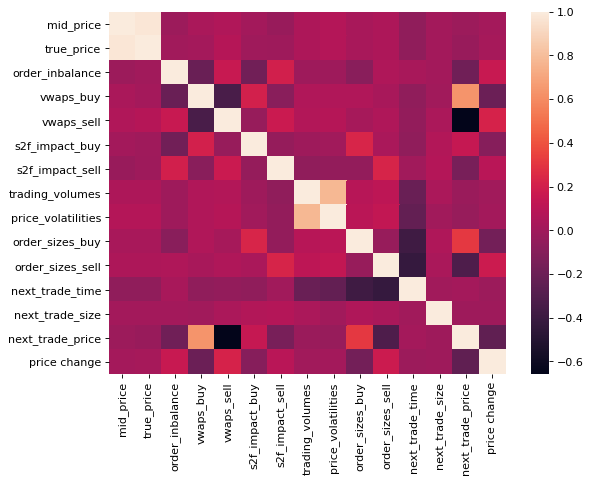

In [74]:
df = pd.DataFrame({
                'mid_price': mid_price.flatten(), 
                'true_price': true_price.flatten(), 
                'order_inbalance': order_inbalance.flatten(), 
                'vwaps_buy': vwaps_buy.flatten(), 
                'vwaps_sell': vwaps_sell.flatten(), 
                's2f_impact_buy': s2f_impact_buy.flatten(), 
                's2f_impact_sell': s2f_impact_sell.flatten(), 
                'trading_volumes': trading_volumes.flatten(), 
                'price_volatilities': price_volatilities.flatten(),
                'order_sizes_buy': order_sizes_buy.flatten(), 
                'order_sizes_sell': order_sizes_sell.flatten(),
                'next_trade_time': next_trade_time.flatten(),
                'next_trade_size': next_trade_size.flatten(),
                'next_trade_price': next_trade_price.flatten(),
                'price change': price_change.flatten()
                })

figure(figsize=(8, 6), dpi=80)
ax = sns.heatmap(df.corr(method='kendall'))
plt.show()

# models

In [51]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier



In [52]:
functions_to_call = {
    'mid_price'                              : get_mid_price_comp,
    'true_price'                             : get_true_price_comp,
    'order_inbalance'                        : get_order_inbalance_comp,
    'vwaps_buy'                              : get_vwap_and_ordersizes_comp,
    'vwaps_sell'                             : get_vwap_and_ordersizes_comp,
    'vwaps_order_sizes_buy'                  : get_vwap_and_ordersizes_comp,
    'vwaps_order_sizes_sell'                 : get_vwap_and_ordersizes_comp,
    's2f_impact_buy'                         : get_s2f_impact_and_ordersizes_comp,
    's2f_impact_sell'                        : get_s2f_impact_and_ordersizes_comp,
    's2f_order_sizes_buy'                    : get_s2f_impact_and_ordersizes_comp,
    's2f_order_sizes_sell'                   : get_s2f_impact_and_ordersizes_comp,
    'trading_volumes'                        : get_trading_volume_and_price_volatility,
    'price_volatilities'                     : get_trading_volume_and_price_volatility,
    'next_trade_time'                        : get_next_trade_x_comp,
    'next_trade_size'                        : get_next_trade_x_comp,
    'next_trade_price'                       : get_next_trade_x_comp,
    'price_change'                           : get_price_change_given_prices
}

In [53]:
def average_smoothing(records, past):      #records - twodimensional array (days, nr_of_bucket), past - how many buckets we look in the past
  #  rolled_records = np.roll(records, past, axis = 1)
   # rolled_records = rolled_records[:,past:]
    rolled_records=records[:,:-past] # does the same as above 
    result = np.zeros(shape = rolled_records.shape)
    for day in range(rolled_records.shape[0]):
        for buck in range(rolled_records.shape[1]):
            count_elem = 0.0
            sum_elem = 0.0
            # loop for changing nans to zeros, np.sum(arr) returns nan if nan is in the arr
            for elem in records[day][buck:buck+past]:
                if not math.isnan(elem):
                    sum_elem+=elem
                    count_elem+=1
            if count_elem>0:
                result[day][buck] = sum_elem/count_elem
            else:
                result[day][buck] = 0
    return result

In [54]:
def up_still_down(x, epsilon = 10e-7):
    if x>epsilon:
        return 1
    elif x<-epsilon:
        return -1
    else:
        return 0
def test_high(x, epsilon = 0.01):
    if x>epsilon:
        return 1
    else:
        return 0
def test_down(x, epsilon = 0.01):
    if x<epsilon:
        return 1
    else:
        return 0
def up_down_bool(x):
    if x>0:
        return True
    else:
        return False
#np.vectorize(up_still_down)(price_change)

In [170]:
def get_y_to_test_max_bool(true_prices, period_of_getting_max, interval_in_data, threshold=10e-7):
    next_indices = period_of_getting_max//interval_in_data
    num_of_days = true_prices.shape[0]
    num_of_averaged_minutes = true_prices.shape[1]
    res = np.empty(true_prices.shape)
    for i in range(num_of_days):
        for j in range(num_of_averaged_minutes):
            max_val=np.max(true_prices[i][j:j+next_indices])
            true_price=true_prices[i,j]
            if true_price==0:
                true_price=prev_true_price
                print("true price at index {},{} was zero!".format(i,j))
            else:
                prev_true_price=true_prices[i,j]
            if (max_val-true_price)/true_price>=threshold: # price swing >= than threshold % of price
                res[i][j] = True
            else:
                res[i,j]=False
    return res
def get_y_to_test_min_bool(true_prices, period_of_getting_min, interval_in_data, threshold=10e-7):
    next_indices = period_of_getting_min//interval_in_data
    num_of_days = true_prices.shape[0]
    num_of_averaged_minutes = true_prices.shape[1]
    res = np.empty(true_prices.shape)
    for i in range(num_of_days):
        for j in range(num_of_averaged_minutes):
            min_val=np.min(true_prices[i][j:j+next_indices])
            true_price=true_prices[i,j]
            if true_price==0:
                true_price=prev_true_price
                print("true price at index {},{} was zero!".format(i,j))
            else:
                prev_true_price=true_prices[i,j]
            if (min_val-true_price)/true_price<=-threshold: # price swing >= than threshold % of price
                res[i][j] = True
            else:
                res[i,j]=False

    return res

In [174]:
def get_X(comp_id=1, 
                    interval=5, 
                    time_to_skip=0, 
                    time_back=1, 
                    names=[], 
                   ): # use up_and_down or not 
    ## NEED TO ADD y_name PARAMETER AND USE IT!!!
    X = np.empty(shape=(-10*time_back+10*((510-time_to_skip)//interval), len(names)))
    #average_smoothing reduces shape "time_back" times per day
    index=0
    s2f_called=False
    vwap_called=False
    volvol_called=False #volume and price volatility
    s2f_imp=np.empty(shape=(10, (510-time_to_skip)//interval))
    s2f_ord=np.empty(shape=(10, (510-time_to_skip)//interval))
    vwap=np.empty(shape=(10, (510-time_to_skip)//interval))
    vwap_ord=np.empty(shape=(10, (510-time_to_skip)//interval))
    volume=np.empty(shape=(10, (510-time_to_skip)//interval))
    volatility=np.empty(shape=(10, (510-time_to_skip)//interval))
    for name in names:
        if name in ['mid_price', 'true_price', 'order_inbalance']:
            arr = functions_to_call[name](comp_id, interval, time_to_skip)
        elif re.search("vwap", name):
            if not vwap_called:
                vwap, vwap_ord=functions_to_call[name](comp_id, interval, time_to_skip)
                vwap_called=True
            if name in ['vwaps_buy']:
                arr = vwap[:,::2]
            elif name in ['vwaps_sell']:
                arr = vwap[:,1::2]
            elif name in ['vwaps_order_sizes_buy']:
                arr = vwap_ord[:,::2]
            elif name in ['vwaps_order_sizes_sell']:
                arr = vwap_ord[:,1::2]
        elif re.search("s2f", name):
            if not s2f_called:
                s2f_imp, s2f_ord=functions_to_call[name](comp_id, interval, time_to_skip)
                s2f_called=True
            if name in ['s2f_impact_buy']:
                arr = s2f_imp[:,::2]
            elif name in ['s2f_impact_sell']:
                arr = s2f_imp[:,1::2]
            elif name in ['s2f_order_sizes_buy']:
                arr = s2f_ord[:,::2]
            elif name in ['s2f_order_sizes_sell']:
                arr = s2f_ord[:,1::2]  
        elif name in ['trading_volumes', 'price_volatilities']:
            if not volvol_called:
                volume, volatility=functions_to_call[name](comp_id, interval, time_to_skip)
                volvol_called=True
            if name == 'trading_volumes':
                arr = volume
            elif name == 'price_volatilities':
                arr = volatility
        elif name == 'next_trade_time':
            arr = functions_to_call[name](comp_id, interval, time_to_skip, get_x='time')
        elif name == 'next_trade_size':
            arr = functions_to_call[name](comp_id, interval, time_to_skip, get_x='size')
        elif name == 'next_trade_price':
            arr = functions_to_call[name](comp_id, interval, time_to_skip, get_x='price')
        X[:,index]=average_smoothing(arr, time_back).flatten()
        index+=1
    return X

def get_y(comp_id=1, 
        interval=5, 
        time_to_skip=0, 
        time_back=1, 
        y_name='true_price', 
        check='change',
        swing_interval=30,
         threshold=1e-2):
    y = functions_to_call[y_name](comp_id, interval, time_to_skip)
   #??? y = average_smoothing(functions_to_call[y_name](comp_id, interval, time_to_skip), time_back)???
    if check=='change':
        y=functions_to_call['price_change'](y)    
        y=np.vectorize(up_still_down)(y)
    elif check=='swing_max':
        y=get_y_to_test_max_bool(y, swing_interval, interval, threshold)
    elif check=='swing_min':
        y=get_y_to_test_min_bool(y, swing_interval, interval, threshold)
    else:
        raise ValueError('bad check argument')
    y = y[:,time_back:].flatten()
    return y

In [176]:
np.unique(get_y())

array([-1,  1])

In [57]:
def get_X_y_raw(comp_id=1, 
                    interval=5, 
                    time_to_skip=30, 
                    names=[], 
                    y_name='true_price',
                   check_change=False): # use up_and_down or not 
    X = np.empty(shape=(len(names), 10, (510-time_to_skip)//interval))  # parameter, days, timestamps
    index=0
    s2f_called=False
    vwap_called=False
    volvol_called=False #volume and price volatility
    s2f_imp=np.empty(shape=(10, (510-time_to_skip)//interval))
    s2f_ord=np.empty(shape=(10, (510-time_to_skip)//interval))
    vwap=np.empty(shape=(10, (510-time_to_skip)//interval))
    vwap_ord=np.empty(shape=(10, (510-time_to_skip)//interval))
    volume=np.empty(shape=(10, (510-time_to_skip)//interval))
    volatility=np.empty(shape=(10, (510-time_to_skip)//interval))
    for name in names:
        if name in ['mid_price', 'true_price', 'order_inbalance']:
            arr = functions_to_call[name](comp_id, interval, time_to_skip)
        elif name in ['trading_volumes', 'price_volatilities']:
            if not volvol_called:
                volume, volatility=functions_to_call[name](comp_id, interval, time_to_skip)
                volvol_called=True
            if name == 'trading_volumes':
                arr = volume
            elif name == 'price_volatilities':
                arr = volatility
        elif name == 'next_trade_time':
            arr = functions_to_call[name](comp_id, interval, time_to_skip, get_x='time')
        elif name == 'next_trade_size':
            arr = functions_to_call[name](comp_id, interval, time_to_skip, get_x='size')
        elif name == 'next_trade_price':
            arr = functions_to_call[name](comp_id, interval, time_to_skip, get_x='price')   
        elif re.search("vwap", name):
            if not vwap_called:
                vwap, vwap_ord=functions_to_call[name](comp_id, interval, time_to_skip)
                vwap_called=True
            if name in ['vwaps_buy']:
                arr = vwap[:,::2]
            elif name in ['vwaps_sell']:
                arr = vwap[:,1::2]
            elif name in ['vwaps_order_sizes_buy']:
                arr = vwap_ord[:,::2]
            elif name in ['vwaps_order_sizes_sell']:
                arr = vwap_ord[:,1::2]
        elif re.search("s2f", name):
            if not s2f_called:
                s2f_imp, s2f_ord=functions_to_call[name](comp_id, interval, time_to_skip)
                s2f_called=True
            if name in ['s2f_impact_buy']:
                arr = s2f_imp[:,::2]
            elif name in ['s2f_impact_sell']:
                arr = s2f_imp[:,1::2]
            elif name in ['s2f_order_sizes_buy']:
                arr = s2f_ord[:,::2]
            elif name in ['s2f_order_sizes_sell']:
                arr = s2f_ord[:,1::2]            
        else:
            raise ValueError('parameter not found')
        X[index]=arr
        index+=1
    y = functions_to_call[y_name](comp_id, interval, time_to_skip)
    if check_change:
        y=functions_to_call['price_change'](y)    
    
    return X, y

In [58]:
def get_X_y_averaged(X_raw, y_raw, time_back):
    X_shape=X_raw.shape # parameters, days, timestamps
    X = np.empty(shape=(-X_shape[1]*time_back+X_shape[1]*X_shape[2], X_shape[0]))## we want features as columns, samples as rows
    y=y_raw[:,time_back:].flatten()
    for i in range(X_shape[0]):
        X[:,i]=average_smoothing(X_raw[i], time_back).flatten()
    return X, y

In [59]:
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
param_dict_logreg={}
for n in names:
    param_dict_logreg[n]=[]

In [105]:
np.exp(1)

2.718281828459045

In [123]:
def logistic_regr(X, y, split_percent, epsilon=1e-6, comp_id=1, 
                               use_scaling=True, 
                               check_up_down=True, 
                               local_names=names,
                               track_params=False):
    if check_up_down:
        y=np.vectorize(up_still_down)(y,epsilon*average_comp_price[comp_id])#currently we hold price change in y
    split=int(y.size*split_percent)
    if use_scaling:
        clf=make_pipeline(preprocessing.MaxAbsScaler(), LogisticRegression(max_iter=20 ,solver='sag', tol=1/np.exp(1))).fit(X[:split], y[:split])
      #  print(clf.named_steps)
        if track_params:
            for i in range(len(local_names)):
                param_dict_logreg[local_names[i]].append( clf.named_steps['logisticregression'].coef_[0,i])
        else:
            print("Coefficient impact:")
            for i in range(len(local_names)):
                print(local_names[i], " ", clf.named_steps['logisticregression'].coef_[0,i])
    else:
        clf = LogisticRegression(max_iter=20).fit(X[:split], y[:split])
        if track_params:
            for i in range(len(local_names)):
                param_dict_logreg[local_names[i]].append( clf.coef_[0,i])  
        else:
            print("Coefficient impact:")
            for i in range(len(local_names)):
                print(local_names[i], " ", clf.coef_[0,i])
    y_predicted=clf.predict(X[split:])
    #print("mse: ", mse(y[split:], y_predicted))
    #print("logistic regr score: ", clf.score(X[split:], y[split:]))
    return clf.score(X[split:], y[split:])

In [61]:
def decision_tree(X, y, split_percent, epsilon, comp_id,
                               use_scaling=False, 
                               check_up_down=True, 
                               local_names=names,
                               track_params=False):
    if check_up_down:
        y=np.vectorize(up_still_down)(y,epsilon*average_comp_price[comp_id])#currently we hold price change in y
    split=int(y.size*split_percent)
    if use_scaling:
        clf=make_pipeline(preprocessing.MaxAbsScaler(), DecisionTreeClassifier()).fit(X[:split], y[:split])
       # print(clf.named_steps)
        if track_params:
            for i in range(len(local_names)):
                param_dict_logreg[local_names[i]].append( clf.named_steps['decisiontreeclassifier'].feature_importances_[i])
        else:
            print("Coefficient impact:")
            for i in range(len(local_names)):
                print(local_names[i], " ", clf.named_steps['decisiontreeclassifier'].feature_importances_[i])
    else:
        clf = DecisionTreeClassifier().fit(X[:split], y[:split])
        if track_params:
            for i in range(len(local_names)):
                param_dict_logreg[local_names[i]].append( clf.feature_importances_[i])  
        else:
            print("Coefficient impact:")
          #  print(clf.feature_importances_)
            for i in range(len(local_names)):
                print(local_names[i], " ", clf.feature_importances_[i])
    y_predicted=clf.predict(X[split:])
    #print("mse: ", mse(y[split:], y_predicted))
    #print("decision tree score: ", clf.score(X[split:], y[split:]))
    return clf.score(X[split:], y[split:])

In [62]:
average_comp_price=np.zeros(len(list_of_companies_number))
for i in range(average_comp_price.size):
    average_comp_price[i]=np.average(get_true_price_comp(comp_id=i, interval=1, time_to_skip=30))

In [108]:
comp_id = 3
interval=5
time_to_skip=30
time_back=1
split_percent = 0.8
epsilon=0.000001

In [94]:
names=[         
   # 'mid_price',
    #'true_price', 
 #   'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
 #   's2f_impact_buy', 
 #   's2f_impact_sell', 
 #   'trading_volumes', 
 #   'price_volatilities',
 #   'vwaps_order_sizes_buy', 
 #   'vwaps_order_sizes_sell',
 #   's2f_order_sizes_buy', 
 #   's2f_order_sizes_sell',
  #  'next_trade_time',
  #  'next_trade_size',
    'next_trade_price',
    #'price change'
      ]

In [144]:
print(average_comp_price[comp_id])
X=get_X(comp_id, interval, time_to_skip, time_back, names)
y=get_y(comp_id, interval, time_to_skip, time_back, y_name='true_price', check='change')
print("decision_tree")
print("score: ",decision_tree(X, np.copy(y),split_percent, epsilon, comp_id, use_scaling=True, local_names=names))
print("log reg")
print("score: ",logistic_regr(X, np.copy(y),split_percent, epsilon, comp_id, use_scaling=True, local_names=names))




851.5752484506002
decision_tree
Coefficient impact:
order_inbalance   0.33200938639862104
vwaps_buy   0.17979587261860303
vwaps_sell   0.16986993924172755
next_trade_price   0.3183248017410484
score:  0.5368421052631579
log reg
Coefficient impact:
order_inbalance   -0.9041716282927897
vwaps_buy   -1.221586907670989
vwaps_sell   1.5168244573724607
next_trade_price   1.1876302910593017
score:  0.5526315789473685


# find best epsilon

In [79]:
interval=5
time_to_skip=30
time_back=1
split_percent = 0.8
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
epsilons=np.concatenate((np.array([0]),np.logspace(-8, -3, num=6)))
comp_eps=np.zeros((len(list_of_companies_number), len(epsilons)))

In [80]:
time_start=time.time()
for comp_id in range(len(list_of_companies_number)//10):
    print(comp_id)
    X=get_X(comp_id, interval, time_to_skip, time_back, names)
    y=get_y(comp_id, interval, time_to_skip, time_back, y_name='true_price', check='change')
    for eps in range(epsilons.size):
        comp_eps[comp_id,eps]=logistic_regr(X, np.copy(y),split_percent, epsilons[eps], comp_id, True, track_params=True)
print("calculations took: {} seconds".format(  time.time()-time_start))

0
31.770833333333332% of intervals were SELL empty
17.864583333333332% of intervals were BUY empty
49.635416666666664% of intervals were set nan
1
26.354166666666668% of intervals were SELL empty
30.260416666666668% of intervals were BUY empty
56.614583333333336% of intervals were set nan
2
23.333333333333332% of intervals were SELL empty
24.479166666666668% of intervals were BUY empty
47.8125% of intervals were set nan
3
31.822916666666668% of intervals were SELL empty
20.052083333333332% of intervals were BUY empty
51.875% of intervals were set nan
4
23.020833333333332% of intervals were SELL empty
26.770833333333332% of intervals were BUY empty
49.791666666666664% of intervals were set nan
5
29.947916666666668% of intervals were SELL empty
35.052083333333336% of intervals were BUY empty
65.0% of intervals were set nan
6
27.65625% of intervals were SELL empty
26.354166666666668% of intervals were BUY empty
54.010416666666664% of intervals were set nan
7
27.708333333333332% of interva

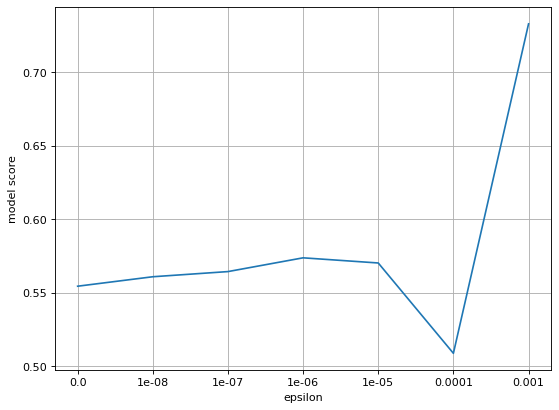

In [81]:
figure(figsize=(8, 6), dpi=80)
plt.axes(xlabel='epsilon', ylabel='model score')
plt.xticks(np.arange(len(epsilons)), epsilons, rotation='0')

plt.grid()

plt.plot(np.sum(comp_eps, axis=0)/9)

## take a look around 1e-6

In [218]:
epsilons=np.arange(start=2e-6,stop=4e-6, step=1e-7)
comp_eps=np.zeros((len(list_of_companies_number), len(epsilons)))

In [219]:
time_start=time.time()
for comp_id in range(len(list_of_companies_number)):
    print(comp_id)
    X=get_X(comp_id, interval, time_to_skip, time_back, names)
    y=get_y(comp_id, interval, time_to_skip, time_back, y_name='true_price', check='change')
    for eps in range(epsilons.size):
        comp_eps[comp_id,eps]=logistic_regr(X, np.copy(y),split_percent, epsilons[eps], comp_id, True, track_params=True)
print("calculations took: {} seconds".format(  time.time()-time_start))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
calculations took: 184.55247974395752 seconds


best epsilon:  2.699999999999999e-06


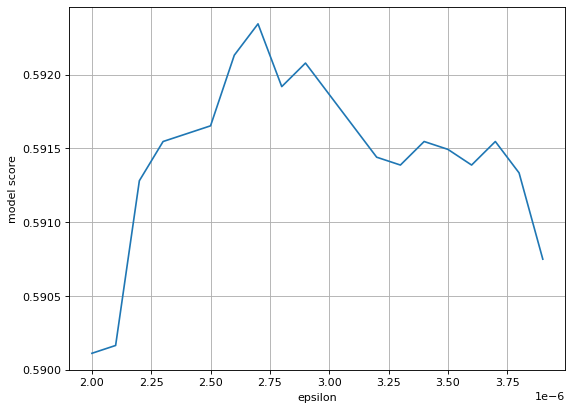

In [223]:
figure(figsize=(8, 6), dpi=80)
plt.axes(xlabel='epsilon', ylabel='model score')
#plt.xticks(np.arange(len(epsilons)), epsilons, rotation='90')

plt.grid()
print("best epsilon: ", epsilons[np.argmax(np.sum(comp_eps, axis=0))])
plt.plot(epsilons, np.sum(comp_eps, axis=0)/99)


In [225]:
2.7e-6

2.7e-06

# try with different features

In [82]:
interval=5
time_to_skip=30
time_back=1
split_percent = 0.8
epsilon=2.7e-6
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
names_dict={}
for name in names:
    names_dict[name]=[]

In [84]:
comps=np.arange(len(list_of_companies_number)//10)
comps_X=[]
comps_y=[]
skipped_params=['none']+names
names_len=len(names)
scores=np.zeros(shape=(len(comps), names_len+1))
for c in range(len(comps)):
   # X,y=get_X_y_classic(comps[c], interval, time_to_skip, time_back, names, y_name='true_price', check_change=True)
    X=get_X(comps[c], interval, time_to_skip, time_back, names)
    y=get_y(comps[c], interval, time_to_skip, time_back, y_name='true_price', check='change')
    scores[c,0]=logistic_regr(X, np.copy(y),split_percent, epsilon, comps[c], True, local_names=names)
    comps_X.append(X)
    comps_y.append(y)
for c in range(len(comps)):
    for i in range(1, names_len+1):
        name=names.pop(0)
        scores[c,i]=logistic_regr(np.delete(comps_X[c], i-1, 1), 
                                               np.copy(comps_y[c]),split_percent, 
                                               epsilon, comps[c], True, local_names=names)
        names.append(name)
      #  skipped_params.append(name)
        print('skipped ', name, '\n')
        #AFTER SCALING


31.770833333333332% of intervals were SELL empty
17.864583333333332% of intervals were BUY empty
49.635416666666664% of intervals were set nan
Coefficient impact:
order_inbalance   -0.3303121695358861
vwaps_buy   -0.7304213167343723
vwaps_sell   0.8199257266756945
s2f_impact_buy   0.13359961692184305
s2f_impact_sell   0.41969969926659256
trading_volumes   0.19534699049331722
price_volatilities   0.12953633538539153
vwaps_order_sizes_buy   0.4968648266590866
vwaps_order_sizes_sell   -0.44127635076672256
s2f_order_sizes_buy   0.0012799084014456527
s2f_order_sizes_sell   -0.23248959529164245
next_trade_time   -0.6016278532181222
next_trade_size   0.1694912200376477
next_trade_price   1.2417835925529768
26.354166666666668% of intervals were SELL empty
30.260416666666668% of intervals were BUY empty
56.614583333333336% of intervals were set nan
Coefficient impact:
order_inbalance   -0.003260354000470427
vwaps_buy   -1.5576516055344676
vwaps_sell   1.8764083795141848
s2f_impact_buy   -0.1515

next_trade_size   0.0430752485207546
next_trade_price   -0.2273202934765122
order_inbalance   -0.6100124989637209
vwaps_buy   0.16682434768177995
vwaps_sell   1.251497532472787
skipped  s2f_impact_buy 

Coefficient impact:
trading_volumes   -0.34588812527226115
price_volatilities   -0.776043542594765
vwaps_order_sizes_buy   0.8827922265914574
vwaps_order_sizes_sell   0.0735147791823534
s2f_order_sizes_buy   0.17649276050274018
s2f_order_sizes_sell   0.18285508097289171
next_trade_time   0.48877284375793595
next_trade_size   -0.44899825271989136
next_trade_price   0.007651834675478205
order_inbalance   -0.05561577700757665
vwaps_buy   -0.6308515406195646
vwaps_sell   0.1682143357365618
s2f_impact_buy   1.2083177940239977
skipped  s2f_impact_sell 

Coefficient impact:
price_volatilities   -0.331318654334027
vwaps_order_sizes_buy   -0.7296247178860766
vwaps_order_sizes_sell   0.8203917065542948
s2f_order_sizes_buy   0.13101910694578212
s2f_order_sizes_sell   0.41698508367241366
next_trade

s2f_order_sizes_buy   -1.5622639948232993
s2f_order_sizes_sell   1.8898573933166438
next_trade_time   -0.127565312632646
next_trade_size   -0.07169893730735427
next_trade_price   0.17356411435695074
order_inbalance   -0.35092623534071093
vwaps_buy   0.6031156077887674
vwaps_sell   0.4610684436886438
s2f_impact_buy   -0.10508482724060376
s2f_impact_sell   0.3637168661475503
trading_volumes   0.0915123662378065
price_volatilities   1.8024896354971691
skipped  vwaps_order_sizes_buy 

Coefficient impact:
s2f_order_sizes_buy   -0.0011647840594514298
s2f_order_sizes_sell   -1.5547059365288631
next_trade_time   1.8741706078538267
next_trade_size   -0.1536079157275832
next_trade_price   -0.09611746937792517
order_inbalance   0.4916903575063429
vwaps_buy   -0.3418594366327815
vwaps_sell   -0.654286976081874
s2f_impact_buy   0.47713507238348707
s2f_impact_sell   -0.09668374942284251
trading_volumes   0.3507646913583795
price_volatilities   0.09593746059531987
vwaps_order_sizes_buy   1.7938266663

s2f_impact_buy   -0.17288184374671742
s2f_impact_sell   0.3879925108912232
trading_volumes   0.5150215293971826
price_volatilities   0.5279337524891402
vwaps_order_sizes_buy   -0.08093433583780318
vwaps_order_sizes_sell   -0.12185860560568529
s2f_order_sizes_buy   2.199276139966597
skipped  s2f_order_sizes_sell 

Coefficient impact:
next_trade_size   -0.3253423407587968
next_trade_price   -2.1600736420576694
order_inbalance   1.6624126120054834
vwaps_buy   -0.14501349276754738
vwaps_sell   0.4690285681645148
s2f_impact_buy   -0.4629896753043243
s2f_impact_sell   -0.15215953852154632
trading_volumes   0.40375058950037856
price_volatilities   0.35533160436256495
vwaps_order_sizes_buy   0.5383999265779938
vwaps_order_sizes_sell   0.522884101917475
s2f_order_sizes_buy   -0.0814326512336564
s2f_order_sizes_sell   2.1897113641179895
skipped  next_trade_time 

Coefficient impact:
next_trade_price   -0.32592241052218696
order_inbalance   -2.159580443949226
vwaps_buy   1.6626970534811718
vwaps_

Coefficient impact:
next_trade_price   -0.7894995288121583
order_inbalance   -1.1019999453745204
vwaps_buy   1.4190801445691994
vwaps_sell   0.017880994167743174
s2f_impact_buy   0.2850291283090243
s2f_impact_sell   0.27027753973569957
trading_volumes   -0.37881194790888645
price_volatilities   0.07160273233123689
vwaps_order_sizes_buy   0.6736312069532325
vwaps_order_sizes_sell   0.3254643164090169
s2f_order_sizes_buy   -0.11117663398879143
s2f_order_sizes_sell   -0.27720156595688117
next_trade_time   1.0896622480826006
skipped  next_trade_size 

Coefficient impact:
order_inbalance   -0.8148554490202654
vwaps_buy   -0.0942014442081601
vwaps_sell   0.3036872854818876
s2f_impact_buy   0.05597954100420044
s2f_impact_sell   0.2497802244375584
trading_volumes   0.31346657780153564
price_volatilities   -0.40069126711841563
vwaps_order_sizes_buy   0.11877573541200298
vwaps_order_sizes_sell   0.6813503769427153
s2f_order_sizes_buy   0.2907630694569187
s2f_order_sizes_sell   -0.097501891347247

Coefficient impact:
vwaps_buy   -1.3901060947739545
vwaps_sell   0.9295405898509566
s2f_impact_buy   0.15083908704015098
s2f_impact_sell   0.08386887070874928
trading_volumes   -0.09849331397185937
price_volatilities   0.20093702456658424
vwaps_order_sizes_buy   -0.8598491164741404
vwaps_order_sizes_sell   0.5953716724897659
s2f_order_sizes_buy   -0.23491690306415536
s2f_order_sizes_sell   -0.04326676814181953
next_trade_time   -0.29608681525627795
next_trade_size   -0.32965929141887307
next_trade_price   1.6434328541629184
skipped  order_inbalance 

Coefficient impact:
vwaps_sell   -0.575394890621247
s2f_impact_buy   0.32212152401938443
s2f_impact_sell   0.25516303298133075
trading_volumes   0.18157768830866391
price_volatilities   -0.12315514014819581
vwaps_order_sizes_buy   0.23024814165552598
vwaps_order_sizes_sell   -0.9399815054627445
s2f_order_sizes_buy   0.6959415465790424
s2f_order_sizes_sell   -0.40234711590034267
next_trade_time   -0.05953360868626165
next_trade_size   -0.29

s2f_impact_buy   0.6456312337768381
s2f_impact_sell   0.34669899740302756
trading_volumes   0.5872231701225932
price_volatilities   0.10430140692458531
vwaps_order_sizes_buy   -0.23299537049290597
vwaps_order_sizes_sell   0.17868831548746067
s2f_order_sizes_buy   0.12947266108980962
s2f_order_sizes_sell   -0.045105105276041065
next_trade_time   0.04236133777525409
next_trade_size   -0.6443383512584369
next_trade_price   -0.4427866517493939
order_inbalance   0.524915818794986
skipped  vwaps_buy 

Coefficient impact:
s2f_impact_buy   0.4298188603295791
s2f_impact_sell   -0.2439008698610634
trading_volumes   0.21595792561688623
price_volatilities   0.5844162461825261
vwaps_order_sizes_buy   0.14620803475550864
vwaps_order_sizes_sell   -0.11547890010224718
s2f_order_sizes_buy   0.2005417387197051
s2f_order_sizes_sell   0.09947499525727976
next_trade_time   0.12959190536417553
next_trade_size   0.01580195765604808
next_trade_price   -0.6805378500588594
order_inbalance   -0.434045543250678
v

vwaps_buy   0.021753766265858322
vwaps_sell   -2.590696032496994
skipped  s2f_impact_buy 

Coefficient impact:
trading_volumes   0.7277404731355162
price_volatilities   1.6755867333587398
vwaps_order_sizes_buy   -1.790488019080986
vwaps_order_sizes_sell   0.013388124340973489
s2f_order_sizes_buy   -0.49000822653743603
s2f_order_sizes_sell   0.08975279566509324
next_trade_time   0.07588313169770541
next_trade_size   -0.3601537047436736
next_trade_price   0.27175263175814335
order_inbalance   -0.8175932901493527
vwaps_buy   -0.10425948772095996
vwaps_sell   0.06046536888079952
s2f_impact_buy   -2.5085496974912904
skipped  s2f_impact_sell 

Coefficient impact:
price_volatilities   0.7481246142337773
vwaps_order_sizes_buy   1.5932968332078619
vwaps_order_sizes_sell   -1.7908212588354797
s2f_order_sizes_buy   -0.03568629703048221
s2f_order_sizes_sell   -0.4979391316499051
next_trade_time   0.14144069357563935
next_trade_size   -0.13470929234661394
next_trade_price   -0.626067969932867
order

Coefficient impact:
s2f_order_sizes_buy   -0.22076741671821987
s2f_order_sizes_sell   -2.103561490261457
next_trade_time   2.1544052558441433
next_trade_size   -0.07918402028228666
next_trade_price   -0.0734477739107203
order_inbalance   0.11383170541608016
vwaps_buy   0.13805078220371794
vwaps_sell   -0.796029762016867
s2f_impact_buy   0.2370947822570105
s2f_impact_sell   0.520708712741651
trading_volumes   -0.6354635137286696
price_volatilities   0.6330902181214477
vwaps_order_sizes_buy   1.8111129060401199
skipped  vwaps_order_sizes_sell 

Coefficient impact:
s2f_order_sizes_sell   -0.21470669475149384
next_trade_time   -2.096380300642031
next_trade_size   2.1599477544809287
next_trade_price   0.03749193770683185
order_inbalance   -0.06785025630691274
vwaps_buy   0.07681599451777063
vwaps_sell   0.12727154240728525
s2f_impact_buy   -0.7429409321773575
s2f_impact_sell   0.14315493272297883
trading_volumes   0.5135557005054223
price_volatilities   -0.6520019032237095
vwaps_order_sizes

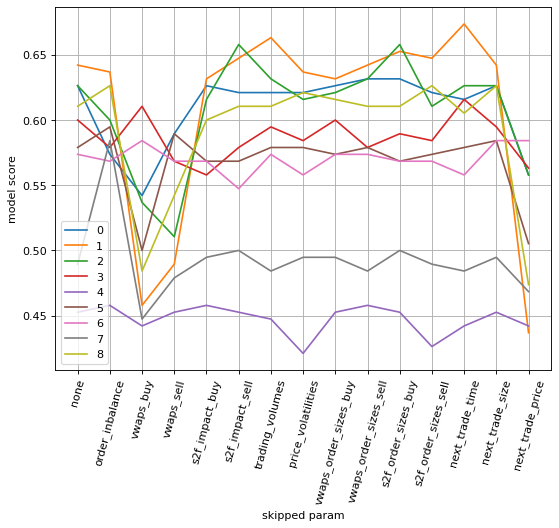

In [86]:
figure(figsize=(8, 6), dpi=80)

plt.axes(xlabel='skipped param', ylabel='model score')
plt.xticks(np.arange(len(skipped_params)), skipped_params, rotation='75')
plt.grid()
for c in range(len(comps)):
    plt.plot( scores[c])
#plt.plot(np.sum(scores, axis=0)/len(comps))
#plt.legend(['all_comps'])
plt.legend(comps)
 ### LOG REg

In [87]:
comps=np.arange(len(list_of_companies_number))
comps_X=[]
comps_y=[]
skipped_params=['none']+names
names_len=len(names)
scores=np.zeros(shape=(len(comps), names_len+1))
for c in range(len(comps)):
   # X,y=get_X_y_classic(comps[c], interval, time_to_skip, time_back, names, y_name='true_price', check_change=True)
    X=get_X(comps[c], interval, time_to_skip, time_back, names)
    y=get_y(comps[c], interval, time_to_skip, time_back, y_name='true_price', check='change')
    scores[c,0]=decision_tree(X, np.copy(y),split_percent, epsilon, comps[c], True, local_names=names)
    comps_X.append(X)
    comps_y.append(y)
for c in range(len(comps)):
    for i in range(1, names_len+1):
        name=names.pop(0)
        scores[c,i]=decision_tree(np.delete(comps_X[c], i-1, 1), 
                                               np.copy(comps_y[c]),split_percent, 
                                               epsilon, comps[c], True, local_names=names)
        names.append(name)
      #  skipped_params.append(name)
        print('skipped ', name, '\n')
        #AFTER SCALING


31.770833333333332% of intervals were SELL empty
17.864583333333332% of intervals were BUY empty
49.635416666666664% of intervals were set nan
Coefficient impact:
order_inbalance   0.1428630148500407
vwaps_buy   0.10662730704147813
vwaps_sell   0.022459627364259518
s2f_impact_buy   0.07416370176336083
s2f_impact_sell   0.08260766363672317
trading_volumes   0.07254595198696018
price_volatilities   0.008240275765665906
vwaps_order_sizes_buy   0.03428030838651118
vwaps_order_sizes_sell   0.009839168467688017
s2f_order_sizes_buy   0.01025544576861561
s2f_order_sizes_sell   0.015342011012621086
next_trade_time   0.12820036262440837
next_trade_size   0.1330174565705566
next_trade_price   0.1595577047611107
26.354166666666668% of intervals were SELL empty
30.260416666666668% of intervals were BUY empty
56.614583333333336% of intervals were set nan
Coefficient impact:
order_inbalance   0.11962691088065787
vwaps_buy   0.09380264359224094
vwaps_sell   0.06082554025000195
s2f_impact_buy   0.03755

33.229166666666664% of intervals were SELL empty
24.6875% of intervals were BUY empty
57.916666666666664% of intervals were set nan
Coefficient impact:
order_inbalance   0.1501607846247211
vwaps_buy   0.14219289084204295
vwaps_sell   0.02793555515322692
s2f_impact_buy   0.03872710134978541
s2f_impact_sell   0.04946662071374434
trading_volumes   0.09368705314403222
price_volatilities   0.0
vwaps_order_sizes_buy   0.022764069539967752
vwaps_order_sizes_sell   0.03805778016873338
s2f_order_sizes_buy   0.027901029408870178
s2f_order_sizes_sell   0.022184070270483254
next_trade_time   0.11193365053463135
next_trade_size   0.07664800312838829
next_trade_price   0.1983413911213728
27.239583333333332% of intervals were SELL empty
18.020833333333332% of intervals were BUY empty
45.260416666666664% of intervals were set nan
Coefficient impact:
order_inbalance   0.11749545892170508
vwaps_buy   0.06461389077413547
vwaps_sell   0.040553215320753774
s2f_impact_buy   0.08720423455227967
s2f_impact_se

27.604166666666668% of intervals were SELL empty
21.09375% of intervals were BUY empty
48.697916666666664% of intervals were set nan
Coefficient impact:
order_inbalance   0.1278975379766063
vwaps_buy   0.10628929000567736
vwaps_sell   0.032802722932153625
s2f_impact_buy   0.06245210078271939
s2f_impact_sell   0.02618372068518278
trading_volumes   0.11227254060807139
price_volatilities   0.03752747852092417
vwaps_order_sizes_buy   0.031099653761264986
vwaps_order_sizes_sell   0.023802100504193242
s2f_order_sizes_buy   0.04890274683041946
s2f_order_sizes_sell   0.0416478607837848
next_trade_time   0.11835066848772607
next_trade_size   0.10524648062310314
next_trade_price   0.12552509749817337
36.927083333333336% of intervals were SELL empty
31.145833333333332% of intervals were BUY empty
68.07291666666667% of intervals were set nan
Coefficient impact:
order_inbalance   0.0751010087807677
vwaps_buy   0.15012174402249545
vwaps_sell   0.0656910267565145
s2f_impact_buy   0.0357489198424311
s

32.447916666666664% of intervals were SELL empty
36.40625% of intervals were BUY empty
68.85416666666667% of intervals were set nan
Coefficient impact:
order_inbalance   0.11658389952475112
vwaps_buy   0.13206638829482506
vwaps_sell   0.09742584642743503
s2f_impact_buy   0.02933227861412649
s2f_impact_sell   0.051840491175580275
trading_volumes   0.07023899735241643
price_volatilities   0.003926890935771221
vwaps_order_sizes_buy   0.041455496339301234
vwaps_order_sizes_sell   0.04297452344887016
s2f_order_sizes_buy   0.023197245755511863
s2f_order_sizes_sell   0.018534018575354274
next_trade_time   0.07867916923806005
next_trade_size   0.104711276856988
next_trade_price   0.1890334774610087
18.854166666666668% of intervals were SELL empty
30.78125% of intervals were BUY empty
49.635416666666664% of intervals were set nan
Coefficient impact:
order_inbalance   0.10709744905195968
vwaps_buy   0.053429587927902575
vwaps_sell   0.0905263196182349
s2f_impact_buy   0.056136896952826594
s2f_im

26.71875% of intervals were SELL empty
22.239583333333332% of intervals were BUY empty
48.958333333333336% of intervals were set nan
Coefficient impact:
order_inbalance   0.11819680719555019
vwaps_buy   0.10526518556370212
vwaps_sell   0.13170355393750613
s2f_impact_buy   0.08426160277207015
s2f_impact_sell   0.04958795621511076
trading_volumes   0.07205064073020685
price_volatilities   0.0040205922879828345
vwaps_order_sizes_buy   0.04504556355398393
vwaps_order_sizes_sell   0.01723538198162559
s2f_order_sizes_buy   0.03892428212002217
s2f_order_sizes_sell   0.0
next_trade_time   0.11373928053882144
next_trade_size   0.06351748451287033
next_trade_price   0.1564516685905476
22.291666666666668% of intervals were SELL empty
29.114583333333332% of intervals were BUY empty
51.40625% of intervals were set nan
Coefficient impact:
order_inbalance   0.13554612773252842
vwaps_buy   0.021015817846975565
vwaps_sell   0.1031699743155363
s2f_impact_buy   0.06138257038465172
s2f_impact_sell   0.038

44.479166666666664% of intervals were SELL empty
44.895833333333336% of intervals were BUY empty
89.375% of intervals were set nan
Coefficient impact:
order_inbalance   0.04892441008575431
vwaps_buy   0.20959010367088907
vwaps_sell   0.1413188852958325
s2f_impact_buy   0.0071165888474575955
s2f_impact_sell   0.008390083693844743
trading_volumes   0.04101205425117909
price_volatilities   0.07971659480885569
vwaps_order_sizes_buy   0.03237430205715014
vwaps_order_sizes_sell   0.005418595718941397
s2f_order_sizes_buy   0.01390084321093822
s2f_order_sizes_sell   0.009612076910414769
next_trade_time   0.0358584708629212
next_trade_size   0.07677609745291814
next_trade_price   0.289990893132903
24.635416666666668% of intervals were SELL empty
22.604166666666668% of intervals were BUY empty
47.239583333333336% of intervals were set nan
Coefficient impact:
order_inbalance   0.09348711979849082
vwaps_buy   0.08568437420143445
vwaps_sell   0.1301108040468236
s2f_impact_buy   0.05559041368733252


29.114583333333332% of intervals were SELL empty
31.302083333333332% of intervals were BUY empty
60.416666666666664% of intervals were set nan
Coefficient impact:
order_inbalance   0.14072447918230935
vwaps_buy   0.08869937016655977
vwaps_sell   0.08884241809158266
s2f_impact_buy   0.04200957624743672
s2f_impact_sell   0.039970779968679836
trading_volumes   0.08756511353776571
price_volatilities   0.004835384580881111
vwaps_order_sizes_buy   0.056591800082484045
vwaps_order_sizes_sell   0.027973967317646554
s2f_order_sizes_buy   0.03368823950320302
s2f_order_sizes_sell   0.03642195373596388
next_trade_time   0.10711998026939565
next_trade_size   0.08482309607409269
next_trade_price   0.1607338412419991
35.46875% of intervals were SELL empty
31.354166666666668% of intervals were BUY empty
66.82291666666667% of intervals were set nan
Coefficient impact:
order_inbalance   0.13934970787138815
vwaps_buy   0.11062494395305703
vwaps_sell   0.05531347882885575
s2f_impact_buy   0.03694916560456

33.125% of intervals were SELL empty
33.59375% of intervals were BUY empty
66.71875% of intervals were set nan
Coefficient impact:
order_inbalance   0.1499609823935506
vwaps_buy   0.0843579968485208
vwaps_sell   0.08654112497049422
s2f_impact_buy   0.04117579144451233
s2f_impact_sell   0.02856447267052786
trading_volumes   0.05010181020937811
price_volatilities   0.0
vwaps_order_sizes_buy   0.0926735290875469
vwaps_order_sizes_sell   0.041240043205394025
s2f_order_sizes_buy   0.01800513267255106
s2f_order_sizes_sell   0.0205663017448151
next_trade_time   0.07882316449978385
next_trade_size   0.09300939431311103
next_trade_price   0.21498025593981426
25.208333333333332% of intervals were SELL empty
30.260416666666668% of intervals were BUY empty
55.46875% of intervals were set nan
Coefficient impact:
order_inbalance   0.18069098979220102
vwaps_buy   0.02079329966213814
vwaps_sell   0.041769056904241895
s2f_impact_buy   0.04735683163806147
s2f_impact_sell   0.03313488057849507
trading_vo

35.416666666666664% of intervals were SELL empty
40.46875% of intervals were BUY empty
75.88541666666667% of intervals were set nan
Coefficient impact:
order_inbalance   0.12320153311700541
vwaps_buy   0.01742906951066226
vwaps_sell   0.07241012420537449
s2f_impact_buy   0.02612567579807918
s2f_impact_sell   0.058176892505874676
trading_volumes   0.16376464818311257
price_volatilities   0.0
vwaps_order_sizes_buy   0.04924777356745511
vwaps_order_sizes_sell   0.03337409303106962
s2f_order_sizes_buy   0.0487590391583601
s2f_order_sizes_sell   0.004164587466324029
next_trade_time   0.13586079323618938
next_trade_size   0.16588453289614494
next_trade_price   0.10160123732434823
31.822916666666668% of intervals were SELL empty
27.239583333333332% of intervals were BUY empty
59.0625% of intervals were set nan
Coefficient impact:
order_inbalance   0.14714705434862999
vwaps_buy   0.052919342795507696
vwaps_sell   0.06248054547460705
s2f_impact_buy   0.1149086939820919
s2f_impact_sell   0.02672

Coefficient impact:
price_volatilities   0.1729564311110866
vwaps_order_sizes_buy   0.09712456929774906
vwaps_order_sizes_sell   0.06864262780422245
s2f_order_sizes_buy   0.04158722770096725
s2f_order_sizes_sell   0.0423974843335019
next_trade_time   0.008699844775109936
next_trade_size   0.036491697502004525
next_trade_price   0.020419089072154572
order_inbalance   0.03443342962934152
vwaps_buy   0.0392588134664843
vwaps_sell   0.11074349095179094
s2f_impact_buy   0.14170646027576989
s2f_impact_sell   0.1855388340798171
skipped  trading_volumes 

Coefficient impact:
vwaps_order_sizes_buy   0.11253996564400259
vwaps_order_sizes_sell   0.09883377170821409
s2f_order_sizes_buy   0.060106517541718175
s2f_order_sizes_sell   0.06247993032940844
next_trade_time   0.04268124322329422
next_trade_size   0.08251842346425775
next_trade_price   0.057553890323338214
order_inbalance   0.026945602885807232
vwaps_buy   0.02885599372718048
vwaps_sell   0.03102196170850087
s2f_impact_buy   0.115214231478

next_trade_time   0.06277925117798286
next_trade_size   0.0777642018455891
next_trade_price   0.06417911855575313
order_inbalance   0.11756845443058005
vwaps_buy   0.004581372758399757
vwaps_sell   0.010558973405073726
s2f_impact_buy   0.03087923124693651
s2f_impact_sell   0.04228794592382436
trading_volumes   0.15215604457884918
price_volatilities   0.11869869163502002
vwaps_order_sizes_buy   0.11749348674346388
skipped  vwaps_order_sizes_sell 

Coefficient impact:
s2f_order_sizes_sell   0.1489389684853491
next_trade_time   0.06688351630747104
next_trade_size   0.0686216830369724
next_trade_price   0.08626313246564059
order_inbalance   0.0584321780986696
vwaps_buy   0.08868702324099613
vwaps_sell   0.004142654174000412
s2f_impact_buy   0.055368954495900014
s2f_impact_sell   0.018440209809531857
trading_volumes   0.036400565253757816
price_volatilities   0.14687531895385608
vwaps_order_sizes_buy   0.11037980351839907
vwaps_order_sizes_sell   0.1105659921594559
skipped  s2f_order_sizes_

next_trade_size   0.09610409265037696
next_trade_price   0.028276894487663698
order_inbalance   0.03996911073766094
vwaps_buy   0.013042214195190683
vwaps_sell   0.07480514866589612
s2f_impact_buy   0.011751168119950577
s2f_impact_sell   0.01768897887263529
trading_volumes   0.060267954675713206
price_volatilities   0.03902339782618911
vwaps_order_sizes_buy   0.11110049149090216
vwaps_order_sizes_sell   0.17058854668802143
s2f_order_sizes_buy   0.1709789091865378
skipped  s2f_order_sizes_sell 

Coefficient impact:
next_trade_size   0.19649003999656908
next_trade_price   0.11652598977538789
order_inbalance   0.0446469865024774
vwaps_buy   0.04949921610254702
vwaps_sell   0.03303181190395308
s2f_impact_buy   0.060081248071900316
s2f_impact_sell   0.00982579761255029
trading_volumes   0.004435619336041008
price_volatilities   0.06005423131578576
vwaps_order_sizes_buy   0.06127037358703505
vwaps_order_sizes_sell   0.042443576502080235
s2f_order_sizes_buy   0.15780434478279323
s2f_order_siz

s2f_order_sizes_buy   0.03417300558834701
s2f_order_sizes_sell   0.03826119153119544
next_trade_time   0.029253080246955606
next_trade_size   0.12025916981333683
next_trade_price   0.10333444150057373
order_inbalance   0.2031779247936614
skipped  vwaps_buy 

Coefficient impact:
s2f_impact_buy   0.20584595626983196
s2f_impact_sell   0.06241361980689014
trading_volumes   0.028712708440693457
price_volatilities   0.04473393649779475
vwaps_order_sizes_buy   0.07259800319606993
vwaps_order_sizes_sell   0.004187752869502846
s2f_order_sizes_buy   0.04568178343613224
s2f_order_sizes_sell   0.04961547036114533
next_trade_time   0.02504032333574618
next_trade_size   0.032858055904790816
next_trade_price   0.09967738125446245
order_inbalance   0.13163689514809865
vwaps_buy   0.19699811347884127
skipped  vwaps_sell 

Coefficient impact:
s2f_impact_sell   0.15236297163667797
trading_volumes   0.08752256251921252
price_volatilities   0.10537190683698369
vwaps_order_sizes_buy   0.026357065138764842
v

skipped  trading_volumes 

Coefficient impact:
vwaps_order_sizes_buy   0.12064223038627242
vwaps_order_sizes_sell   0.10806729712568726
s2f_order_sizes_buy   0.06768087653716838
s2f_order_sizes_sell   0.04482306117371443
next_trade_time   0.06372699551881858
next_trade_size   0.08745649974618415
next_trade_price   0.04188310648647589
order_inbalance   0.019977026080469997
vwaps_buy   0.03804999791286177
vwaps_sell   0.023528670090727937
s2f_impact_buy   0.08307617174044833
s2f_impact_sell   0.12911170569433983
trading_volumes   0.17197636150683118
skipped  price_volatilities 

Coefficient impact:
vwaps_order_sizes_sell   0.10993757907724212
s2f_order_sizes_buy   0.09930442981409919
s2f_order_sizes_sell   0.07269549920023807
next_trade_time   0.046753014740291504
next_trade_size   0.046619823114019646
next_trade_price   0.0835966883888354
order_inbalance   0.035705368167072614
vwaps_buy   0.017420367963221165
vwaps_sell   0.045579680255103804
s2f_impact_buy   0.04004157088705662
s2f_imp

s2f_order_sizes_sell   0.10420947735864003
next_trade_time   0.10173956798492224
next_trade_size   0.03908019586341837
next_trade_price   0.0391900821229348
order_inbalance   0.0859768497506053
vwaps_buy   0.00719701956545338
vwaps_sell   0.04673914094342983
s2f_impact_buy   0.027146979890838425
s2f_impact_sell   0.04883508282218112
trading_volumes   0.1020526176166717
price_volatilities   0.0810752438004404
vwaps_order_sizes_buy   0.19172030451605862
skipped  vwaps_order_sizes_sell 

Coefficient impact:
s2f_order_sizes_sell   0.1207434264288151
next_trade_time   0.08607118909249954
next_trade_size   0.10416498670787713
next_trade_price   0.04499723648667609
order_inbalance   0.04777232698151404
vwaps_buy   0.09602432931184854
vwaps_sell   0.00969842270710486
s2f_impact_buy   0.05022314062685729
s2f_impact_sell   0.03588541192345808
trading_volumes   0.01801034812627187
price_volatilities   0.09651964278002755
vwaps_order_sizes_buy   0.10542776950678855
vwaps_order_sizes_sell   0.18446

skipped  s2f_order_sizes_sell 

Coefficient impact:
next_trade_size   0.13137788505864875
next_trade_price   0.04611614729919604
order_inbalance   0.13552785958870867
vwaps_buy   0.03818717602294354
vwaps_sell   0.040600804371209574
s2f_impact_buy   0.07568936809317237
s2f_impact_sell   0.012604108141971493
trading_volumes   0.061616883886609554
price_volatilities   0.052946794449799967
vwaps_order_sizes_buy   0.03475450738622605
vwaps_order_sizes_sell   0.029121946829017066
s2f_order_sizes_buy   0.12099776994935522
s2f_order_sizes_sell   0.22045874892314166
skipped  next_trade_time 

Coefficient impact:
next_trade_price   0.09555498735748146
order_inbalance   0.0538919367820634
vwaps_buy   0.13072941564632934
vwaps_sell   0.03460224395487769
s2f_impact_buy   0.04663362718932483
s2f_impact_sell   0.10054412320373546
trading_volumes   0.0
price_volatilities   0.06169111213864077
vwaps_order_sizes_buy   0.0529238697832908
vwaps_order_sizes_sell   0.03624614689152351
s2f_order_sizes_buy  

skipped  next_trade_time 

Coefficient impact:
next_trade_price   0.15396920728418143
order_inbalance   0.0766200780549372
vwaps_buy   0.11048246056831106
vwaps_sell   0.07507977381698652
s2f_impact_buy   0.040063377113439054
s2f_impact_sell   0.07071035998384911
trading_volumes   0.002807717528839138
price_volatilities   0.07743417386233703
vwaps_order_sizes_buy   0.037813269658826545
vwaps_order_sizes_sell   0.028786275131481076
s2f_order_sizes_buy   0.024587389913977756
s2f_order_sizes_sell   0.10961820049363694
next_trade_time   0.19202771658919712
skipped  next_trade_size 

Coefficient impact:
order_inbalance   0.11244729238579267
vwaps_buy   0.10552453461826265
vwaps_sell   0.05020062590990795
s2f_impact_buy   0.10839987658348112
s2f_impact_sell   0.04726878709851289
trading_volumes   0.0977836115129054
price_volatilities   0.04260405147052787
vwaps_order_sizes_buy   0.08554545333911964
vwaps_order_sizes_sell   0.04659153434090544
s2f_order_sizes_buy   0.021205367577041088
s2f_or

Coefficient impact:
vwaps_buy   0.07568335735842102
vwaps_sell   0.07196059534657999
s2f_impact_buy   0.07122269691981062
s2f_impact_sell   0.05898725737881993
trading_volumes   0.1074955787360741
price_volatilities   0.0
vwaps_order_sizes_buy   0.05848017054078908
vwaps_order_sizes_sell   0.03515534056401064
s2f_order_sizes_buy   0.03398428468936944
s2f_order_sizes_sell   0.04167308334803147
next_trade_time   0.1312180263155979
next_trade_size   0.1889438090569364
next_trade_price   0.12519579974555944
skipped  order_inbalance 

Coefficient impact:
vwaps_sell   0.18709266062263105
s2f_impact_buy   0.05750366520500484
s2f_impact_sell   0.06025829605179773
trading_volumes   0.05428656726067411
price_volatilities   0.09952543883042736
vwaps_order_sizes_buy   0.0
vwaps_order_sizes_sell   0.05745001667742129
s2f_order_sizes_buy   0.035301728095682376
s2f_order_sizes_sell   0.030436781118327844
next_trade_time   0.0191782561036237
next_trade_size   0.11010763754332031
next_trade_price   0.1

next_trade_price   0.033702979502360626
order_inbalance   0.048563860163915326
vwaps_buy   0.03346783768842109
vwaps_sell   0.009865349403675977
s2f_impact_buy   0.0916887155536572
s2f_impact_sell   0.09608556012488818
trading_volumes   0.18649631756206972
skipped  price_volatilities 

Coefficient impact:
vwaps_order_sizes_sell   0.15200282242876137
s2f_order_sizes_buy   0.13663672605789265
s2f_order_sizes_sell   0.040106688182232654
next_trade_time   0.04191513128965218
next_trade_size   0.05207107295631479
next_trade_price   0.09944448889706609
order_inbalance   0.0
vwaps_buy   0.04242484150476063
vwaps_sell   0.04346409588838105
s2f_impact_buy   0.01188387071981764
s2f_impact_sell   0.09541437190475935
trading_volumes   0.10191858174457058
price_volatilities   0.182717308425791
skipped  vwaps_order_sizes_buy 

Coefficient impact:
s2f_order_sizes_buy   0.17166985741026464
s2f_order_sizes_sell   0.15472652455124417
next_trade_time   0.053854973427227275
next_trade_size   0.04339098756

Coefficient impact:
next_trade_time   0.14224331137918955
next_trade_size   0.07981270439640681
next_trade_price   0.04051285890919931
order_inbalance   0.06320874617825602
vwaps_buy   0.05902179640101463
vwaps_sell   0.0691132392644354
s2f_impact_buy   0.0
s2f_impact_sell   0.03639067955980017
trading_volumes   0.08991387932871783
price_volatilities   0.03541621328464074
vwaps_order_sizes_buy   0.10566275670538634
vwaps_order_sizes_sell   0.10724547470383984
s2f_order_sizes_buy   0.17145833988911346
skipped  s2f_order_sizes_sell 

Coefficient impact:
next_trade_size   0.14533820468611863
next_trade_price   0.07970789114902822
order_inbalance   0.0454642150597803
vwaps_buy   0.06430610145701222
vwaps_sell   0.07541533891908268
s2f_impact_buy   0.08647879729043907
s2f_impact_sell   0.0
trading_volumes   0.04901711641798655
price_volatilities   0.05829779491180866
vwaps_order_sizes_buy   0.04540667712192798
vwaps_order_sizes_sell   0.03650294617951749
s2f_order_sizes_buy   0.134308855760

s2f_impact_sell   0.0573859784361809
trading_volumes   0.05716317214675089
price_volatilities   0.09944469706280842
vwaps_order_sizes_buy   0.0677528292689569
vwaps_order_sizes_sell   0.004089263561221111
s2f_order_sizes_buy   0.03860976888661263
s2f_order_sizes_sell   0.029803807271631597
next_trade_time   0.023305388332664965
next_trade_size   0.029202862844255044
next_trade_price   0.11043695364205505
order_inbalance   0.1615510091720781
vwaps_buy   0.1238645576607838
skipped  vwaps_sell 

Coefficient impact:
s2f_impact_sell   0.14813479251187608
trading_volumes   0.08274673969315342
price_volatilities   0.070804827906545
vwaps_order_sizes_buy   0.069713432523858
vwaps_order_sizes_sell   0.1008958146605757
s2f_order_sizes_buy   0.01474569590818047
s2f_order_sizes_sell   0.021822844554178576
next_trade_time   0.02854982027106324
next_trade_size   0.027398982364669942
next_trade_price   0.04236059051710144
order_inbalance   0.11965231386039833
vwaps_buy   0.1259996695035526
vwaps_sell

skipped  s2f_order_sizes_buy 

Coefficient impact:
next_trade_time   0.1423627978934288
next_trade_size   0.06746379963144733
next_trade_price   0.1268292050400136
order_inbalance   0.06640165966356985
vwaps_buy   0.04375070036484451
vwaps_sell   0.08448847256350363
s2f_impact_buy   0.009385644276128001
s2f_impact_sell   0.012181758640007073
trading_volumes   0.07735532280436959
price_volatilities   0.04101888031616257
vwaps_order_sizes_buy   0.07912557090441848
vwaps_order_sizes_sell   0.08925012412502831
s2f_order_sizes_buy   0.16038606377707823
skipped  s2f_order_sizes_sell 

Coefficient impact:
next_trade_size   0.11442708879042494
next_trade_price   0.08369058289370464
order_inbalance   0.13054571715101676
vwaps_buy   0.06614364241702374
vwaps_sell   0.03009677690801201
s2f_impact_buy   0.10001348572801166
s2f_impact_sell   0.0069994635279598625
trading_volumes   0.030467420077361144
price_volatilities   0.03984296676918773
vwaps_order_sizes_buy   0.04741021244649488
vwaps_order_s

Coefficient impact:
s2f_impact_sell   0.09061348540724126
trading_volumes   0.09982094677644078
price_volatilities   0.09438662897620959
vwaps_order_sizes_buy   0.0694993687332685
vwaps_order_sizes_sell   0.06826177839024149
s2f_order_sizes_buy   0.013401439851927493
s2f_order_sizes_sell   0.00818045213901818
next_trade_time   0.040647718919182965
next_trade_size   0.05631582763729373
next_trade_price   0.03449346195944069
order_inbalance   0.14543441735711543
vwaps_buy   0.13362990917096867
vwaps_sell   0.14531456468165124
skipped  s2f_impact_buy 

Coefficient impact:
trading_volumes   0.11566153954739772
price_volatilities   0.07067610052436352
vwaps_order_sizes_buy   0.11668768254560205
vwaps_order_sizes_sell   0.022898239235312295
s2f_order_sizes_buy   0.07873196144610542
s2f_order_sizes_sell   0.010752761784794153
next_trade_time   0.039320086457531
next_trade_size   0.05948163788642146
next_trade_price   0.031653588104110196
order_inbalance   0.023889793734595238
vwaps_buy   0.14

Coefficient impact:
next_trade_time   0.14822109294709998
next_trade_size   0.05865893901199254
next_trade_price   0.07761681662300951
order_inbalance   0.021350921033562984
vwaps_buy   0.053009688585020566
vwaps_sell   0.0682733455741264
s2f_impact_buy   0.007243696608593441
s2f_impact_sell   0.039126577404981856
trading_volumes   0.0868424871248842
price_volatilities   0.021585999519434063
vwaps_order_sizes_buy   0.1368009119144009
vwaps_order_sizes_sell   0.12147479860621666
s2f_order_sizes_buy   0.15979472504667686
skipped  s2f_order_sizes_sell 

Coefficient impact:
next_trade_size   0.1989619552438082
next_trade_price   0.06881627597513748
order_inbalance   0.10846729622895561
vwaps_buy   0.02875899838378932
vwaps_sell   0.05930637527363228
s2f_impact_buy   0.10519446344658961
s2f_impact_sell   0.00390699969840704
trading_volumes   0.04032878646791934
price_volatilities   0.03545883131466629
vwaps_order_sizes_buy   0.019499030736434032
vwaps_order_sizes_sell   0.0488612823714279
s

skipped  order_inbalance 

Coefficient impact:
vwaps_sell   0.18383316252943374
s2f_impact_buy   0.09033861805206568
s2f_impact_sell   0.033434373557074924
trading_volumes   0.05110151001069326
price_volatilities   0.0258095859846919
vwaps_order_sizes_buy   0.00608026405718191
vwaps_order_sizes_sell   0.061972453662591055
s2f_order_sizes_buy   0.035659879093663145
s2f_order_sizes_sell   0.010177499331477286
next_trade_time   0.03398239928817138
next_trade_size   0.09752256485321152
next_trade_price   0.1946434699369027
order_inbalance   0.17544421964284151
skipped  vwaps_buy 

Coefficient impact:
s2f_impact_buy   0.13052486342522548
s2f_impact_sell   0.07185968674454465
trading_volumes   0.04719263232287723
price_volatilities   0.035880796346965144
vwaps_order_sizes_buy   0.08377072135790918
vwaps_order_sizes_sell   0.022928895298209625
s2f_order_sizes_buy   0.04818552292854451
s2f_order_sizes_sell   0.028873018763189668
next_trade_time   0.004690489415540333
next_trade_size   0.038922

skipped  s2f_impact_buy 

Coefficient impact:
trading_volumes   0.22554416370538796
price_volatilities   0.08735691251026774
vwaps_order_sizes_buy   0.07639509017270069
vwaps_order_sizes_sell   0.0328770043409389
s2f_order_sizes_buy   0.09498289277911888
s2f_order_sizes_sell   0.005470332443749968
next_trade_time   0.07024714615100609
next_trade_size   0.020897084354249394
next_trade_price   0.02784832470226193
order_inbalance   0.029591135770782453
vwaps_buy   0.09221616063139575
vwaps_sell   0.11216802221127714
s2f_impact_buy   0.12440573022686305
skipped  s2f_impact_sell 

Coefficient impact:
price_volatilities   0.1741299390486682
vwaps_order_sizes_buy   0.11851122535890468
vwaps_order_sizes_sell   0.06952992492926252
s2f_order_sizes_buy   0.058690516950334115
s2f_order_sizes_sell   0.01272846899070731
next_trade_time   0.0060919611305397334
next_trade_size   0.040361559469476505
next_trade_price   0.053865828300567915
order_inbalance   0.021813976202134946
vwaps_buy   0.0214035566

vwaps_sell   0.007073166841937175
s2f_impact_buy   0.05111373002203804
s2f_impact_sell   0.03390016541417327
trading_volumes   0.016585644273676956
price_volatilities   0.12009686187546918
vwaps_order_sizes_buy   0.13729469139076747
vwaps_order_sizes_sell   0.11156811397762409
skipped  s2f_order_sizes_buy 

Coefficient impact:
next_trade_time   0.18388386875864773
next_trade_size   0.05168536966982217
next_trade_price   0.027276328831237335
order_inbalance   0.057515116150371574
vwaps_buy   0.05847749924840905
vwaps_sell   0.13584079151733608
s2f_impact_buy   0.004446481097237205
s2f_impact_sell   0.05706117134264154
trading_volumes   0.02800471518718
price_volatilities   0.026828202553478873
vwaps_order_sizes_buy   0.08636957839184535
vwaps_order_sizes_sell   0.1484268357373531
s2f_order_sizes_buy   0.13418404151444
skipped  s2f_order_sizes_sell 

Coefficient impact:
next_trade_size   0.19727768695366443
next_trade_price   0.051391216158143925
order_inbalance   0.03712125000965692
vwa

Coefficient impact:
vwaps_buy   0.15695905937817917
vwaps_sell   0.06390961259759093
s2f_impact_buy   0.048569239717729425
s2f_impact_sell   0.023821066939912844
trading_volumes   0.04941427244272232
price_volatilities   0.010500892490143424
vwaps_order_sizes_buy   0.05863272042027198
vwaps_order_sizes_sell   0.03440559681101241
s2f_order_sizes_buy   0.02345713553858216
s2f_order_sizes_sell   0.010421860662300322
next_trade_time   0.0977322771455
next_trade_size   0.14557851684193582
next_trade_price   0.2765977490141191
skipped  order_inbalance 

Coefficient impact:
vwaps_sell   0.14371191143657502
s2f_impact_buy   0.05708365140555283
s2f_impact_sell   0.0902710854567973
trading_volumes   0.01935720019361964
price_volatilities   0.11157967249132172
vwaps_order_sizes_buy   0.011132835620428242
vwaps_order_sizes_sell   0.05598811451221638
s2f_order_sizes_buy   0.022032618374374712
s2f_order_sizes_sell   0.04794631293006276
next_trade_time   0.013407507491928533
next_trade_size   0.11078

s2f_impact_sell   0.19309955832028158
trading_volumes   0.04744545107127893
price_volatilities   0.06362663084592537
vwaps_order_sizes_buy   0.07460191188002126
vwaps_order_sizes_sell   0.06989260391225337
s2f_order_sizes_buy   0.020195743383559017
s2f_order_sizes_sell   0.025226697842256434
next_trade_time   0.044476587448624476
next_trade_size   0.026652893080350678
next_trade_price   0.039046401550588986
order_inbalance   0.13781064880204455
vwaps_buy   0.17104171423865527
vwaps_sell   0.08688315762416003
skipped  s2f_impact_buy 

Coefficient impact:
trading_volumes   0.16513221644473824
price_volatilities   0.04140645348713107
vwaps_order_sizes_buy   0.07657011523562143
vwaps_order_sizes_sell   0.041097576221855926
s2f_order_sizes_buy   0.08153669617890477
s2f_order_sizes_sell   0.025202732544406446
next_trade_time   0.03115350925790638
next_trade_size   0.059612701111928276
next_trade_price   0.03132736910758011
order_inbalance   0.04089296614953877
vwaps_buy   0.15155372538638318

Coefficient impact:
trading_volumes   0.12751579736631422
price_volatilities   0.08173823878034762
vwaps_order_sizes_buy   0.06042087059005199
vwaps_order_sizes_sell   0.07318460161107009
s2f_order_sizes_buy   0.06366054527350849
s2f_order_sizes_sell   0.041046991064554145
next_trade_time   0.02215679001619647
next_trade_size   0.008464504398730147
next_trade_price   0.036172945210006725
order_inbalance   0.016065773516038172
vwaps_buy   0.09602046649290905
vwaps_sell   0.1585373805803638
s2f_impact_buy   0.21501509509990904
skipped  s2f_impact_sell 

Coefficient impact:
price_volatilities   0.10761572879137633
vwaps_order_sizes_buy   0.0845750542743348
vwaps_order_sizes_sell   0.026432253734728524
s2f_order_sizes_buy   0.07835763699198174
s2f_order_sizes_sell   0.01608414245561176
next_trade_time   0.09985801709734775
next_trade_size   0.033759896728504164
next_trade_price   0.017245843992414897
order_inbalance   0.04163474607234895
vwaps_buy   0.009728819712909636
vwaps_sell   0.1206

Coefficient impact:
s2f_order_sizes_sell   0.1382795995714633
next_trade_time   0.08851088526043405
next_trade_size   0.09635442913359579
next_trade_price   0.05232547335846637
order_inbalance   0.06841421824742247
vwaps_buy   0.0652250063754478
vwaps_sell   0.0038505028990149857
s2f_impact_buy   0.03289271250572544
s2f_impact_sell   0.007048058566302309
trading_volumes   0.04095701099244438
price_volatilities   0.11683736033495248
vwaps_order_sizes_buy   0.12464675740084
vwaps_order_sizes_sell   0.16465798535389065
skipped  s2f_order_sizes_buy 

Coefficient impact:
next_trade_time   0.11044198232273736
next_trade_size   0.09163149249486273
next_trade_price   0.10878493769609916
order_inbalance   0.05201397836535819
vwaps_buy   0.06498906604691375
vwaps_sell   0.07132642806606587
s2f_impact_buy   0.003493385550254189
s2f_impact_sell   0.026900570745555148
trading_volumes   0.022199834758265282
price_volatilities   0.02217151982891033
vwaps_order_sizes_buy   0.09733747308867179
vwaps_or

Coefficient impact:
order_inbalance   0.18093647814034555
vwaps_buy   0.0895022777046006
vwaps_sell   0.07848901093386833
s2f_impact_buy   0.02301514282080411
s2f_impact_sell   0.05548343783101726
trading_volumes   0.08208670018489476
price_volatilities   0.0
vwaps_order_sizes_buy   0.07849071370196027
vwaps_order_sizes_sell   0.0642643246228828
s2f_order_sizes_buy   0.03664871081414707
s2f_order_sizes_sell   0.03109010389490332
next_trade_time   0.14151111016670692
next_trade_size   0.13848198918386898
skipped  next_trade_price 

Coefficient impact:
vwaps_buy   0.0930136151795582
vwaps_sell   0.0769443102846767
s2f_impact_buy   0.085005106912135
s2f_impact_sell   0.06218343079941518
trading_volumes   0.08261969612973832
price_volatilities   0.0
vwaps_order_sizes_buy   0.036169151263273185
vwaps_order_sizes_sell   0.04456034605402105
s2f_order_sizes_buy   0.051115551790752445
s2f_order_sizes_sell   0.029690356806472043
next_trade_time   0.14209549787015852
next_trade_size   0.135334028

Coefficient impact:
price_volatilities   0.11565085524686242
vwaps_order_sizes_buy   0.11651981144707982
vwaps_order_sizes_sell   0.11373547083160526
s2f_order_sizes_buy   0.07089719336567717
s2f_order_sizes_sell   0.06316167856254833
next_trade_time   0.0
next_trade_size   0.03636706972201604
next_trade_price   0.07427709919727553
order_inbalance   0.02018402452063281
vwaps_buy   0.014480561336870505
vwaps_sell   0.0627237901889777
s2f_impact_buy   0.10793110853878045
s2f_impact_sell   0.2040713370416739
skipped  trading_volumes 

Coefficient impact:
vwaps_order_sizes_buy   0.05391413188277594
vwaps_order_sizes_sell   0.059046081068751546
s2f_order_sizes_buy   0.06274161893374128
s2f_order_sizes_sell   0.08585460966438527
next_trade_time   0.094479179374122
next_trade_size   0.10995716240922922
next_trade_price   0.053040900822320804
order_inbalance   0.02151117112084594
vwaps_buy   0.04656216677554578
vwaps_sell   0.023776727386540186
s2f_impact_buy   0.09171362068742807
s2f_impact_s

Coefficient impact:
vwaps_order_sizes_sell   0.12335614604005081
s2f_order_sizes_buy   0.030659314856061787
s2f_order_sizes_sell   0.1109284083568742
next_trade_time   0.019258110378699754
next_trade_size   0.07317130207553735
next_trade_price   0.03990622437379886
order_inbalance   0.01713267742969571
vwaps_buy   0.07478410307617758
vwaps_sell   0.010889604958410033
s2f_impact_buy   0.0430684000772798
s2f_impact_sell   0.14843480284170374
trading_volumes   0.12461230220834972
price_volatilities   0.18379860332736073
skipped  vwaps_order_sizes_buy 

Coefficient impact:
s2f_order_sizes_buy   0.12788962038339347
s2f_order_sizes_sell   0.02991761230809114
next_trade_time   0.1087014216409516
next_trade_size   0.012844653608287486
next_trade_price   0.06412425716796522
order_inbalance   0.055614373190812076
vwaps_buy   0.010890680765810162
vwaps_sell   0.022341253781829933
s2f_impact_buy   0.01949632124824152
s2f_impact_sell   0.059488898474586875
trading_volumes   0.16005007129725674
pric

Coefficient impact:
s2f_order_sizes_buy   0.1486628449169235
s2f_order_sizes_sell   0.060314437372880475
next_trade_time   0.1183947393510001
next_trade_size   0.05089384440746814
next_trade_price   0.02664259669765464
order_inbalance   0.08575161442689663
vwaps_buy   0.06804150754238945
vwaps_sell   0.013686546741851203
s2f_impact_buy   0.04284144903372559
s2f_impact_sell   0.044140294803161124
trading_volumes   0.0908892030377141
price_volatilities   0.11216928970165677
vwaps_order_sizes_buy   0.13757163196667826
skipped  vwaps_order_sizes_sell 

Coefficient impact:
s2f_order_sizes_sell   0.0962245797768386
next_trade_time   0.07393665311647622
next_trade_size   0.13165436884762724
next_trade_price   0.03833441030557594
order_inbalance   0.05590738965669928
vwaps_buy   0.09147325506658323
vwaps_sell   0.07250955406545308
s2f_impact_buy   0.020143302361558053
s2f_impact_sell   0.021694469553784276
trading_volumes   0.04930163771291366
price_volatilities   0.05705285064621807
vwaps_ord

Coefficient impact:
next_trade_price   0.15302626789955381
order_inbalance   0.10242216559006276
vwaps_buy   0.0639717969101589
vwaps_sell   0.06254987900929931
s2f_impact_buy   0.05347786360142431
s2f_impact_sell   0.030326170457175106
trading_volumes   0.01964728324550787
price_volatilities   0.04652632058924639
vwaps_order_sizes_buy   0.03764468727684137
vwaps_order_sizes_sell   0.06512408635782044
s2f_order_sizes_buy   0.02736667532176755
s2f_order_sizes_sell   0.19178524001155361
next_trade_time   0.14613156372958874
skipped  next_trade_size 

Coefficient impact:
order_inbalance   0.2096186959758214
vwaps_buy   0.04489024676268956
vwaps_sell   0.04931850688327311
s2f_impact_buy   0.10965331665864289
s2f_impact_sell   0.07654088796773396
trading_volumes   0.02369230852110774
price_volatilities   0.039578524714132236
vwaps_order_sizes_buy   0.021282350071443894
vwaps_order_sizes_sell   0.03339656857567814
s2f_order_sizes_buy   0.03613279934084274
s2f_order_sizes_sell   0.01873574976

Coefficient impact:
vwaps_sell   0.13662102526343944
s2f_impact_buy   0.10919764297377511
s2f_impact_sell   0.019959026002021905
trading_volumes   0.03969503085608161
price_volatilities   0.07836316436421557
vwaps_order_sizes_buy   0.004169842521443932
vwaps_order_sizes_sell   0.036257909394530746
s2f_order_sizes_buy   0.028426191127994854
s2f_order_sizes_sell   0.04068086249361839
next_trade_time   0.029161556742798606
next_trade_size   0.16081503736833608
next_trade_price   0.1507091548416427
order_inbalance   0.16594355605010105
skipped  vwaps_buy 

Coefficient impact:
s2f_impact_buy   0.16563048964400126
s2f_impact_sell   0.1274626358658028
trading_volumes   0.024505217694050535
price_volatilities   0.02527404249116957
vwaps_order_sizes_buy   0.06773844090797482
vwaps_order_sizes_sell   0.0
s2f_order_sizes_buy   0.03757931749963509
s2f_order_sizes_sell   0.07344880788122547
next_trade_time   0.032273319170593104
next_trade_size   0.014561228914359748
next_trade_price   0.0891991848

vwaps_order_sizes_buy   0.11702212204234497
vwaps_order_sizes_sell   0.07738142557082359
s2f_order_sizes_buy   0.06254036930544592
s2f_order_sizes_sell   0.01305289761748334
next_trade_time   0.011590633680703509
next_trade_size   0.0975296008213641
next_trade_price   0.03358872484810311
order_inbalance   0.06201821564733614
vwaps_buy   0.09614540625016355
vwaps_sell   0.09390818857475859
s2f_impact_buy   0.18016339603443954
skipped  s2f_impact_sell 

Coefficient impact:
price_volatilities   0.11496728138792867
vwaps_order_sizes_buy   0.04056710587440591
vwaps_order_sizes_sell   0.07735422253955672
s2f_order_sizes_buy   0.014603056088224604
s2f_order_sizes_sell   0.09201487043158456
next_trade_time   0.012979258781409016
next_trade_size   0.07033855302792896
next_trade_price   0.06525649565475701
order_inbalance   0.03150705518059919
vwaps_buy   0.06840898665030094
vwaps_sell   0.12634348275414886
s2f_impact_buy   0.14001953869153683
s2f_impact_sell   0.1456400929376187
skipped  tradin

Coefficient impact:
vwaps_order_sizes_sell   0.10865960055873752
s2f_order_sizes_buy   0.061363861229310146
s2f_order_sizes_sell   0.046901123225793595
next_trade_time   0.06335098778583398
next_trade_size   0.015212053531154311
next_trade_price   0.09506580268170015
order_inbalance   0.02277401656185207
vwaps_buy   0.06594974481827091
vwaps_sell   0.07433350503607797
s2f_impact_buy   0.021467278848232293
s2f_impact_sell   0.1553123135048169
trading_volumes   0.15612472958889806
price_volatilities   0.11348498262932201
skipped  vwaps_order_sizes_buy 

Coefficient impact:
s2f_order_sizes_buy   0.12159625309907827
s2f_order_sizes_sell   0.048106470826533375
next_trade_time   0.0417985618438018
next_trade_size   0.047174444552622215
next_trade_price   0.03936383822740426
order_inbalance   0.08381514384250252
vwaps_buy   0.03282664790632118
vwaps_sell   0.03584512473887057
s2f_impact_buy   0.054871102637685576
s2f_impact_sell   0.058227937927532725
trading_volumes   0.14986427779195755
pri

s2f_order_sizes_sell   0.04899010935765411
next_trade_time   0.0897659901310223
next_trade_size   0.03435280028919049
next_trade_price   0.059308421645473626
order_inbalance   0.031726010946959364
vwaps_buy   0.043991993184280834
vwaps_sell   0.03579043655619849
s2f_impact_buy   0.05203487338383111
s2f_impact_sell   0.04736621339224282
trading_volumes   0.1259905698802308
price_volatilities   0.09746071651484618
vwaps_order_sizes_buy   0.17893820258730095
skipped  vwaps_order_sizes_sell 

Coefficient impact:
s2f_order_sizes_sell   0.12096629824146518
next_trade_time   0.08135159363001841
next_trade_size   0.08360102403596414
next_trade_price   0.043333767789382464
order_inbalance   0.05246882494529861
vwaps_buy   0.07387084360353977
vwaps_sell   0.03159583171382124
s2f_impact_buy   0.04234762926892874
s2f_impact_sell   0.027313501265806346
trading_volumes   0.03628797463126791
price_volatilities   0.11212595599479651
vwaps_order_sizes_buy   0.12126586775590129
vwaps_order_sizes_sell   

Coefficient impact:
vwaps_buy   0.06929206466097185
vwaps_sell   0.04419460563405091
s2f_impact_buy   0.03264245647846262
s2f_impact_sell   0.07792439120132513
trading_volumes   0.13390125370199296
price_volatilities   0.0
vwaps_order_sizes_buy   0.06474771885073356
vwaps_order_sizes_sell   0.056114721141724846
s2f_order_sizes_buy   0.020151426018518933
s2f_order_sizes_sell   0.02616210957998033
next_trade_time   0.10337520755412544
next_trade_size   0.19136220068951534
next_trade_price   0.18013184448859818
skipped  order_inbalance 

Coefficient impact:
vwaps_sell   0.18033234585852906
s2f_impact_buy   0.04465012604001773
s2f_impact_sell   0.033241777622750636
trading_volumes   0.062470024819992837
price_volatilities   0.11893787708744522
vwaps_order_sizes_buy   0.0
vwaps_order_sizes_sell   0.03948808938801554
s2f_order_sizes_buy   0.054575267209773015
s2f_order_sizes_sell   0.022988248754569045
next_trade_time   0.01800803917419251
next_trade_size   0.1619920102818802
next_trade_pric

Coefficient impact:
vwaps_order_sizes_buy   0.13938231337650606
vwaps_order_sizes_sell   0.10107216849907359
s2f_order_sizes_buy   0.03283970004909782
s2f_order_sizes_sell   0.0635252327839423
next_trade_time   0.028051876577226305
next_trade_size   0.05956734074676882
next_trade_price   0.03076526519363688
order_inbalance   0.01976805956916144
vwaps_buy   0.027909916237982026
vwaps_sell   0.027116950533801424
s2f_impact_buy   0.11366999683527762
s2f_impact_sell   0.19212002070198095
trading_volumes   0.16421115889554466
skipped  price_volatilities 

Coefficient impact:
vwaps_order_sizes_sell   0.1475936308549017
s2f_order_sizes_buy   0.09501051307992642
s2f_order_sizes_sell   0.04386879594218476
next_trade_time   0.06332031863958038
next_trade_size   0.03293539188576167
next_trade_price   0.07023283061100052
order_inbalance   0.016547132144960775
vwaps_buy   0.005877171580438653
vwaps_sell   0.03739098374288605
s2f_impact_buy   0.03397174033655921
s2f_impact_sell   0.12957266370074047

Coefficient impact:
next_trade_size   0.08661212875914492
next_trade_price   0.1013765314812404
order_inbalance   0.17598933690306642
vwaps_buy   0.01909449598616214
vwaps_sell   0.020524332347632478
s2f_impact_buy   0.03505276110463703
s2f_impact_sell   0.072380986061833
trading_volumes   0.02881551508670901
price_volatilities   0.013056231970531792
vwaps_order_sizes_buy   0.011171534556759235
vwaps_order_sizes_sell   0.03310306909795539
s2f_order_sizes_buy   0.13448910586581936
s2f_order_sizes_sell   0.26833397077850885
skipped  next_trade_time 

Coefficient impact:
next_trade_price   0.09703698442568713
order_inbalance   0.08435482761512146
vwaps_buy   0.1957919839103405
vwaps_sell   0.03405232236513558
s2f_impact_buy   0.029035830224415943
s2f_impact_sell   0.021928489720279422
trading_volumes   0.03385329688202504
price_volatilities   0.05150620744133112
vwaps_order_sizes_buy   0.03695978934663861
vwaps_order_sizes_sell   0.03212271988080978
s2f_order_sizes_buy   0.033062113415162

vwaps_order_sizes_buy   0.0501147664393261
vwaps_order_sizes_sell   0.08859360062263875
s2f_order_sizes_buy   0.0034466416785144975
s2f_order_sizes_sell   0.0650404933893577
next_trade_time   0.06336041969503697
next_trade_size   0.01772558577521742
next_trade_price   0.03320423237855896
order_inbalance   0.1165403282093736
vwaps_buy   0.11443984494073678
vwaps_sell   0.1825364730425189
skipped  s2f_impact_buy 

Coefficient impact:
trading_volumes   0.12034677721269904
price_volatilities   0.04501775684224262
vwaps_order_sizes_buy   0.0999756978553317
vwaps_order_sizes_sell   0.04148793460327425
s2f_order_sizes_buy   0.07839873747308365
s2f_order_sizes_sell   0.0
next_trade_time   0.049828747974165116
next_trade_size   0.06770400600718152
next_trade_price   0.04378968841313586
order_inbalance   0.03375280226773053
vwaps_buy   0.08908357535271987
vwaps_sell   0.11659243906851581
s2f_impact_buy   0.2140218369299201
skipped  s2f_impact_sell 

Coefficient impact:
price_volatilities   0.125

skipped  vwaps_order_sizes_buy 

Coefficient impact:
s2f_order_sizes_buy   0.1565099599307542
s2f_order_sizes_sell   0.05611691354426942
next_trade_time   0.07110787415294827
next_trade_size   0.020237852816316487
next_trade_price   0.03180870305017615
order_inbalance   0.09474048240428415
vwaps_buy   0.028803862149449105
vwaps_sell   0.054728159848446124
s2f_impact_buy   0.015655742684491793
s2f_impact_sell   0.04994946288770353
trading_volumes   0.1554057456705334
price_volatilities   0.061770550992012896
vwaps_order_sizes_buy   0.20316468986861447
skipped  vwaps_order_sizes_sell 

Coefficient impact:
s2f_order_sizes_sell   0.09924082262397742
next_trade_time   0.09584023718728392
next_trade_size   0.1293484488276666
next_trade_price   0.01910301709157267
order_inbalance   0.024259144402526172
vwaps_buy   0.04083619317558371
vwaps_sell   0.025155556417172348
s2f_impact_buy   0.03379817895312091
s2f_impact_sell   0.06848935065706362
trading_volumes   0.03100456814316029
price_volatili

Coefficient impact:
next_trade_price   0.23352097923684056
order_inbalance   0.043101569274965626
vwaps_buy   0.18386780669539296
vwaps_sell   0.05608623246810194
s2f_impact_buy   0.07896709520857512
s2f_impact_sell   0.06641034879581038
trading_volumes   0.013373485890383343
price_volatilities   0.009602519758944265
vwaps_order_sizes_buy   0.06638796208568716
vwaps_order_sizes_sell   0.0248285562781654
s2f_order_sizes_buy   0.03442090609324718
s2f_order_sizes_sell   0.0779134082861682
next_trade_time   0.11151912992771766
skipped  next_trade_size 

Coefficient impact:
order_inbalance   0.16410176988359673
vwaps_buy   0.06908084743608392
vwaps_sell   0.1266002394238498
s2f_impact_buy   0.05319027360131448
s2f_impact_sell   0.06548006029188824
trading_volumes   0.08510845632533415
price_volatilities   0.0
vwaps_order_sizes_buy   0.053746454540238235
vwaps_order_sizes_sell   0.04736318404380942
s2f_order_sizes_buy   0.02278804596173332
s2f_order_sizes_sell   0.05493315022727585
next_trad

price_volatilities   0.11034296304528265
vwaps_order_sizes_buy   0.04766256973476629
vwaps_order_sizes_sell   0.05925170336249814
s2f_order_sizes_buy   0.0
s2f_order_sizes_sell   0.05248662207613868
next_trade_time   0.03150731105085585
next_trade_size   0.07012723033537772
next_trade_price   0.014116831940414838
order_inbalance   0.10141789965267843
vwaps_buy   0.14321505721839312
vwaps_sell   0.16621946127025952
skipped  s2f_impact_buy 

Coefficient impact:
trading_volumes   0.14074676331672734
price_volatilities   0.023697985353032334
vwaps_order_sizes_buy   0.12433697669169426
vwaps_order_sizes_sell   0.06577633648874001
s2f_order_sizes_buy   0.052457161564236195
s2f_order_sizes_sell   0.0
next_trade_time   0.04736875027555423
next_trade_size   0.025055667447301276
next_trade_price   0.06347266502562957
order_inbalance   0.016192406159062703
vwaps_buy   0.11694521151920545
vwaps_sell   0.1711690107046227
s2f_impact_buy   0.15278106545419384
skipped  s2f_impact_sell 

Coefficient im

s2f_impact_buy   0.054509446993231715
s2f_impact_sell   0.1296255872512295
trading_volumes   0.1350173164644633
price_volatilities   0.11668512916994656
skipped  vwaps_order_sizes_buy 

Coefficient impact:
s2f_order_sizes_buy   0.1472059315607251
s2f_order_sizes_sell   0.03302101598864003
next_trade_time   0.09795237120503676
next_trade_size   0.03732929990905256
next_trade_price   0.05492436225903407
order_inbalance   0.08973912266099492
vwaps_buy   0.04616827760851946
vwaps_sell   0.01633274829841635
s2f_impact_buy   0.03134145565203389
s2f_impact_sell   0.04931309495536667
trading_volumes   0.13387473129455119
price_volatilities   0.10699212486185296
vwaps_order_sizes_buy   0.15580546374577614
skipped  vwaps_order_sizes_sell 

Coefficient impact:
s2f_order_sizes_sell   0.18784039314340972
next_trade_time   0.04406816005366763
next_trade_size   0.10214844129827834
next_trade_price   0.029379981160308592
order_inbalance   0.031130404040954643
vwaps_buy   0.06959055452275972
vwaps_sell

trading_volumes   0.07585598721789381
price_volatilities   0.02043921934244796
vwaps_order_sizes_buy   0.024626388126292593
vwaps_order_sizes_sell   0.03758589062615531
s2f_order_sizes_buy   0.058167493689732376
s2f_order_sizes_sell   0.05131864997715449
next_trade_time   0.1507777462747678
next_trade_size   0.1716399227556374
skipped  next_trade_price 

Coefficient impact:
vwaps_buy   0.09844129845315076
vwaps_sell   0.10596391060494798
s2f_impact_buy   0.07583173859338883
s2f_impact_sell   0.034345319852801974
trading_volumes   0.06378372966696713
price_volatilities   0.008874023071669263
vwaps_order_sizes_buy   0.05260109772507801
vwaps_order_sizes_sell   0.02550797157438546
s2f_order_sizes_buy   0.03939407025246978
s2f_order_sizes_sell   0.02349877306108016
next_trade_time   0.17824234733964703
next_trade_size   0.10084971081144276
next_trade_price   0.19266600899297084
skipped  order_inbalance 

Coefficient impact:
vwaps_sell   0.1291281505672314
s2f_impact_buy   0.084883834648394

Coefficient impact:
trading_volumes   0.09367963517473185
price_volatilities   0.2081433634125973
vwaps_order_sizes_buy   0.07654602068248434
vwaps_order_sizes_sell   0.008534892284609245
s2f_order_sizes_buy   0.06553538053621964
s2f_order_sizes_sell   0.05628842466449701
next_trade_time   0.03298947305699103
next_trade_size   0.04940666883691217
next_trade_price   0.030092657654560703
order_inbalance   0.01135239594465988
vwaps_buy   0.05617915707184881
vwaps_sell   0.08111450409260963
s2f_impact_buy   0.23013742658727854
skipped  s2f_impact_sell 

Coefficient impact:
price_volatilities   0.10710389314783605
vwaps_order_sizes_buy   0.20116052403223486
vwaps_order_sizes_sell   0.06874357008574612
s2f_order_sizes_buy   0.0
s2f_order_sizes_sell   0.006850353277870968
next_trade_time   0.08402324852547982
next_trade_size   0.06078453597991953
next_trade_price   0.0703423021295269
order_inbalance   0.0332287453390534
vwaps_buy   0.013096892072653372
vwaps_sell   0.05301100162312748
s2f_imp

vwaps_buy   0.0034840889451233058
vwaps_sell   0.00240402137213508
s2f_impact_buy   0.0360198952625873
s2f_impact_sell   0.08716544574568265
trading_volumes   0.03319319206669807
price_volatilities   0.07846192476059678
vwaps_order_sizes_buy   0.0
vwaps_order_sizes_sell   0.028900686826719903
s2f_order_sizes_buy   0.09680011424517068
s2f_order_sizes_sell   0.21160757672857544
skipped  next_trade_time 

Coefficient impact:
next_trade_price   0.126723232362922
order_inbalance   0.05903260515607132
vwaps_buy   0.22945209455391322
vwaps_sell   0.0026130667088424793
s2f_impact_buy   0.00240402137213508
s2f_impact_sell   0.04819867628948727
trading_volumes   0.10772406495788486
price_volatilities   0.03579541668057146
vwaps_order_sizes_buy   0.04975987570624719
vwaps_order_sizes_sell   0.0034840889451233058
s2f_order_sizes_buy   0.02362153466421785
s2f_order_sizes_sell   0.06744351586605503
next_trade_time   0.24374780673652888
skipped  next_trade_size 

Coefficient impact:
order_inbalance  

next_trade_time   0.020613509840330765
next_trade_size   0.071246700673077
next_trade_price   0.014624194586082067
order_inbalance   0.016479596119485324
vwaps_buy   0.06965263380647091
vwaps_sell   0.08971918404429509
s2f_impact_buy   0.27600268965954483
skipped  s2f_impact_sell 

Coefficient impact:
price_volatilities   0.052789238891271
vwaps_order_sizes_buy   0.1080605386630122
vwaps_order_sizes_sell   0.15428893800618398
s2f_order_sizes_buy   0.008576998050682258
s2f_order_sizes_sell   0.0341095091095091
next_trade_time   0.059203806678272776
next_trade_size   0.046835354691916735
next_trade_price   0.09673884180824407
order_inbalance   0.020939984059766274
vwaps_buy   0.021216438224748477
vwaps_sell   0.05231158499149174
s2f_impact_buy   0.0700876705222406
s2f_impact_sell   0.2748410963026607
skipped  trading_volumes 

Coefficient impact:
vwaps_order_sizes_buy   0.037484767726253775
vwaps_order_sizes_sell   0.08270654809779626
s2f_order_sizes_buy   0.16497928567021586
s2f_order_s

skipped  next_trade_time 

Coefficient impact:
next_trade_price   0.13688828788087776
order_inbalance   0.14632661768566252
vwaps_buy   0.08897323277691234
vwaps_sell   0.003497436747015674
s2f_impact_buy   0.007443868752094174
s2f_impact_sell   0.06290725146234988
trading_volumes   0.10090826856265883
price_volatilities   0.06983991217715814
vwaps_order_sizes_buy   0.025932268946599234
vwaps_order_sizes_sell   0.007694360843434483
s2f_order_sizes_buy   0.0
s2f_order_sizes_sell   0.07573890297850772
next_trade_time   0.2738495911867292
skipped  next_trade_size 

Coefficient impact:
order_inbalance   0.18725796960836127
vwaps_buy   0.05583084153013821
vwaps_sell   0.050173412464276854
s2f_impact_buy   0.018890566967599363
s2f_impact_sell   0.01733593267490342
trading_volumes   0.1540039327329477
price_volatilities   0.12223827617564635
vwaps_order_sizes_buy   0.1072716180751174
vwaps_order_sizes_sell   0.03309320203376173
s2f_order_sizes_buy   0.0026230775602617555
s2f_order_sizes_sell 

vwaps_buy   0.21368820089500049
skipped  vwaps_sell 

Coefficient impact:
s2f_impact_sell   0.08490029949615474
trading_volumes   0.10683841300561914
price_volatilities   0.15852584604846728
vwaps_order_sizes_buy   0.008327151605067567
vwaps_order_sizes_sell   0.07997563553168187
s2f_order_sizes_buy   0.051643736232037545
s2f_order_sizes_sell   0.03371280724337408
next_trade_time   0.011902286768876946
next_trade_size   0.008644030112808749
next_trade_price   0.04586880655096996
order_inbalance   0.07320135117386704
vwaps_buy   0.06350245465348124
vwaps_sell   0.2729571815775937
skipped  s2f_impact_buy 

Coefficient impact:
trading_volumes   0.09614196783333707
price_volatilities   0.09414438277002588
vwaps_order_sizes_buy   0.1389587837215074
vwaps_order_sizes_sell   0.006218091373216393
s2f_order_sizes_buy   0.06164092348561246
s2f_order_sizes_sell   0.0776574882359335
next_trade_time   0.03472970944811671
next_trade_size   0.027412476941776412
next_trade_price   0.003989552359757884

Coefficient impact:
vwaps_order_sizes_sell   0.06640375111459755
s2f_order_sizes_buy   0.21899149209568836
s2f_order_sizes_sell   0.13427573905773985
next_trade_time   0.0
next_trade_size   0.001966425865744862
next_trade_price   0.06131704269400152
order_inbalance   0.07690362795560816
vwaps_buy   0.0
vwaps_sell   0.016522744365264706
s2f_impact_buy   0.01882150471498654
s2f_impact_sell   0.046404730274680756
trading_volumes   0.0774767399462592
price_volatilities   0.2809162019154286
skipped  vwaps_order_sizes_buy 

Coefficient impact:
s2f_order_sizes_buy   0.058569217105900295
s2f_order_sizes_sell   0.21562776916927573
next_trade_time   0.1386135600138684
next_trade_size   0.0
next_trade_price   0.0045883270200713444
order_inbalance   0.047853967739612015
vwaps_buy   0.08590548858546244
vwaps_sell   0.036523538201392605
s2f_impact_buy   0.018395530904069337
s2f_impact_sell   0.01071082052639049
trading_volumes   0.0454085471886801
price_volatilities   0.07577935883948772
vwaps_order

skipped  next_trade_time 

Coefficient impact:
next_trade_price   0.09525977137558433
order_inbalance   0.10271975671260457
vwaps_buy   0.1501542534923347
vwaps_sell   0.07696005226545163
s2f_impact_buy   0.04876743599533902
s2f_impact_sell   0.06477742924932935
trading_volumes   0.015759949966667356
price_volatilities   0.02692507303518348
vwaps_order_sizes_buy   0.02363546247499176
vwaps_order_sizes_sell   0.01601417077386644
s2f_order_sizes_buy   0.041081434546913244
s2f_order_sizes_sell   0.09306100099672825
next_trade_time   0.24488420911500572
skipped  next_trade_size 

Coefficient impact:
order_inbalance   0.12665820430153693
vwaps_buy   0.11120985584498906
vwaps_sell   0.07236198783891638
s2f_impact_buy   0.06150488534356906
s2f_impact_sell   0.08768746442238143
trading_volumes   0.10691879877393885
price_volatilities   0.011317063336609322
vwaps_order_sizes_buy   0.034791524194307595
vwaps_order_sizes_sell   0.024711853097221667
s2f_order_sizes_buy   0.019102208005529583
s2f_o

Coefficient impact:
price_volatilities   0.0785665050893804
vwaps_order_sizes_buy   0.07074894604525972
vwaps_order_sizes_sell   0.11980017408254166
s2f_order_sizes_buy   0.05265812633614949
s2f_order_sizes_sell   0.03679465364737339
next_trade_time   0.029638255585747248
next_trade_size   0.07765237432194995
next_trade_price   0.05204005068171482
order_inbalance   0.014742202868235176
vwaps_buy   0.013922387683119332
vwaps_sell   0.10289183778246191
s2f_impact_buy   0.11368725874816327
s2f_impact_sell   0.2368572271279035
skipped  trading_volumes 

Coefficient impact:
vwaps_order_sizes_buy   0.08058593631033963
vwaps_order_sizes_sell   0.08489867791119256
s2f_order_sizes_buy   0.13750039405118844
s2f_order_sizes_sell   0.03240022666409486
next_trade_time   0.027516534596983888
next_trade_size   0.06539179980753249
next_trade_price   0.06370047682501422
order_inbalance   0.03912024109536795
vwaps_buy   0.017722422790180464
vwaps_sell   0.0036342364198308167
s2f_impact_buy   0.087395784

Coefficient impact:
next_trade_size   0.11307319837142832
next_trade_price   0.09488864516837407
order_inbalance   0.11759977090345176
vwaps_buy   0.0
vwaps_sell   0.003976858035168401
s2f_impact_buy   0.05593613634600807
s2f_impact_sell   0.11869468228495957
trading_volumes   0.034916282396636814
price_volatilities   0.03660923613678539
vwaps_order_sizes_buy   0.02039597324475611
vwaps_order_sizes_sell   0.037939555695845985
s2f_order_sizes_buy   0.11848661355662576
s2f_order_sizes_sell   0.24748304785995956
skipped  next_trade_time 

Coefficient impact:
next_trade_price   0.15728331766496267
order_inbalance   0.049556421711416804
vwaps_buy   0.11406381263997256
vwaps_sell   0.014581812795617474
s2f_impact_buy   0.015446195881511707
s2f_impact_sell   0.08827497991072196
trading_volumes   0.09797900552920469
price_volatilities   0.05203128045730514
vwaps_order_sizes_buy   0.05433562952625671
vwaps_order_sizes_sell   0.021302780691076096
s2f_order_sizes_buy   0.039625636465170505
s2f_or

Coefficient impact:
s2f_impact_sell   0.10280433572965324
trading_volumes   0.15073227086137658
price_volatilities   0.027755123074487326
vwaps_order_sizes_buy   0.0067939734429904464
vwaps_order_sizes_sell   0.08796354388709905
s2f_order_sizes_buy   0.06870636973323543
s2f_order_sizes_sell   0.03610420305847848
next_trade_time   0.0331084478135368
next_trade_size   0.027240560574352337
next_trade_price   0.04579370991195416
order_inbalance   0.07566085156585765
vwaps_buy   0.164846242663674
vwaps_sell   0.17249036768330436
skipped  s2f_impact_buy 

Coefficient impact:
trading_volumes   0.10279624705785986
price_volatilities   0.14911465813685504
vwaps_order_sizes_buy   0.03385227872845311
vwaps_order_sizes_sell   0.011323289071650746
s2f_order_sizes_buy   0.07233710413237453
s2f_order_sizes_sell   0.06064387553208413
next_trade_time   0.03026356610148829
next_trade_size   0.027511253310092125
next_trade_price   0.03610464032818131
order_inbalance   0.04338516587408388
vwaps_buy   0.08

s2f_order_sizes_buy   0.10598393418608926
s2f_order_sizes_sell   0.2142597483484228
next_trade_time   0.02049079914287834
next_trade_size   0.017586844534026
next_trade_price   0.09621678041502976
order_inbalance   0.04102224186512189
vwaps_buy   0.013689592643726925
vwaps_sell   0.010445802093283761
s2f_impact_buy   0.0026114505233209404
s2f_impact_sell   0.06574005602746087
trading_volumes   0.06358429395339776
price_volatilities   0.2678129980716804
skipped  vwaps_order_sizes_buy 

Coefficient impact:
s2f_order_sizes_buy   0.07622260270649209
s2f_order_sizes_sell   0.12330289849705464
next_trade_time   0.21406723757266513
next_trade_size   0.024360494009253907
next_trade_price   0.01571195697882122
order_inbalance   0.05786185069618784
vwaps_buy   0.03907608945131366
vwaps_sell   0.03953213957369639
s2f_impact_buy   0.006963868062189172
s2f_impact_sell   0.008953544651386078
trading_volumes   0.0676459813109531
price_volatilities   0.056935458017831404
vwaps_order_sizes_buy   0.2693

Coefficient impact:
s2f_order_sizes_sell   0.12175346668105533
next_trade_time   0.08459007053595685
next_trade_size   0.06268267726517592
next_trade_price   0.033071263891942204
order_inbalance   0.04957102059331291
vwaps_buy   0.11679346213198742
vwaps_sell   0.08807734578434638
s2f_impact_buy   0.034842576768160674
s2f_impact_sell   0.05090590324634261
trading_volumes   0.004835402069163724
price_volatilities   0.11811567041653628
vwaps_order_sizes_buy   0.07768277414515225
vwaps_order_sizes_sell   0.15707836647086748
skipped  s2f_order_sizes_buy 

Coefficient impact:
next_trade_time   0.13895371634547415
next_trade_size   0.08823042408823155
next_trade_price   0.05050427947907487
order_inbalance   0.05141687214854663
vwaps_buy   0.055407938639143464
vwaps_sell   0.13351696260799492
s2f_impact_buy   0.09457207299078388
s2f_impact_sell   0.018641670581396385
trading_volumes   0.03334433247227356
price_volatilities   0.014214225539185606
vwaps_order_sizes_buy   0.09248532354854994
vwa

skipped  next_trade_size 

Coefficient impact:
order_inbalance   0.13353539053151126
vwaps_buy   0.04242581182075626
vwaps_sell   0.09665496025416068
s2f_impact_buy   0.04164610233000685
s2f_impact_sell   0.08376543243281502
trading_volumes   0.08687385556572726
price_volatilities   0.009979302809756348
vwaps_order_sizes_buy   0.05888951809393404
vwaps_order_sizes_sell   0.06901320985838028
s2f_order_sizes_buy   0.03560637913909188
s2f_order_sizes_sell   0.027934173775678996
next_trade_time   0.13559003888665358
next_trade_size   0.1780858245015275
skipped  next_trade_price 

Coefficient impact:
vwaps_buy   0.11497555047353734
vwaps_sell   0.14002752252677386
s2f_impact_buy   0.024701980621490274
s2f_impact_sell   0.04680146749118595
trading_volumes   0.06033002055338477
price_volatilities   0.011599998278692578
vwaps_order_sizes_buy   0.025123237392111527
vwaps_order_sizes_sell   0.0347207286567994
s2f_order_sizes_buy   0.026305723202428122
s2f_order_sizes_sell   0.02708121622963704
n

trading_volumes   0.06651470357417123
price_volatilities   0.03776315536235646
vwaps_order_sizes_buy   0.06408160921393719
vwaps_order_sizes_sell   0.014161806444053484
s2f_order_sizes_buy   0.024016812470497546
s2f_order_sizes_sell   0.03425772796624134
next_trade_time   0.053360297881131134
next_trade_size   0.032399835477920906
next_trade_price   0.15522227438983696
order_inbalance   0.17467501411395106
vwaps_buy   0.1185518235946333
skipped  vwaps_sell 

Coefficient impact:
s2f_impact_sell   0.15799418283314565
trading_volumes   0.09295800813692025
price_volatilities   0.044764410070079225
vwaps_order_sizes_buy   0.05894062858802097
vwaps_order_sizes_sell   0.08073892748857597
s2f_order_sizes_buy   0.00819335767692575
s2f_order_sizes_sell   0.06139701976281173
next_trade_time   0.03169596761912342
next_trade_size   0.03763922997099834
next_trade_price   0.03732657334399411
order_inbalance   0.13256191359247554
vwaps_buy   0.12064181387096111
vwaps_sell   0.135147967045968
skipped  

Coefficient impact:
trading_volumes   0.1472113963040027
price_volatilities   0.07708206465288593
vwaps_order_sizes_buy   0.09294008532558218
vwaps_order_sizes_sell   0.03501585182181685
s2f_order_sizes_buy   0.10305144062733992
s2f_order_sizes_sell   0.004835384580881111
next_trade_time   0.040714445615280107
next_trade_size   0.05369937072484973
next_trade_price   0.04018079359542608
order_inbalance   0.02605998166406247
vwaps_buy   0.1238384475825596
vwaps_sell   0.0810639879472644
s2f_impact_buy   0.17430674955804906
skipped  s2f_impact_sell 

Coefficient impact:
price_volatilities   0.13577825459433904
vwaps_order_sizes_buy   0.08814022391527908
vwaps_order_sizes_sell   0.0780868389148345
s2f_order_sizes_buy   0.0429267078734499
s2f_order_sizes_sell   0.03980896071585376
next_trade_time   0.0
next_trade_size   0.10985748445151117
next_trade_price   0.06618509442430742
order_inbalance   0.025421739971459887
vwaps_buy   0.032631787386399276
vwaps_sell   0.09922109292051924
s2f_impac

trading_volumes   0.04470532828996773
price_volatilities   0.01570960658400099
vwaps_order_sizes_buy   0.02037127317571813
vwaps_order_sizes_sell   0.025297680620416003
s2f_order_sizes_buy   0.151744121343319
s2f_order_sizes_sell   0.24504070760025362
skipped  next_trade_time 

Coefficient impact:
next_trade_price   0.17844039991289273
order_inbalance   0.10025429822561559
vwaps_buy   0.05016239767265135
vwaps_sell   0.039780835530566806
s2f_impact_buy   0.028412078647339814
s2f_impact_sell   0.0922925139359465
trading_volumes   0.011757441173421108
price_volatilities   0.052797081846295627
vwaps_order_sizes_buy   0.04225319886094306
vwaps_order_sizes_sell   0.03246506234705726
s2f_order_sizes_buy   0.022938927559499105
s2f_order_sizes_sell   0.1049370215089976
next_trade_time   0.24350874277877343
skipped  next_trade_size 

Coefficient impact:
order_inbalance   0.18152948612318354
vwaps_buy   0.0902119218905624
vwaps_sell   0.05907911586353149
s2f_impact_buy   0.03056304814518328
s2f_

price_volatilities   0.02136095620565452
vwaps_order_sizes_buy   0.05074574670795277
vwaps_order_sizes_sell   0.03654832212217133
s2f_order_sizes_buy   0.10568495227573341
s2f_order_sizes_sell   0.022770701263428773
next_trade_time   0.16536348148681132
next_trade_size   0.07731108421272942
skipped  next_trade_price 

Coefficient impact:
vwaps_buy   0.11423523320558099
vwaps_sell   0.09608132235751339
s2f_impact_buy   0.0031030818263963877
s2f_impact_sell   0.02239340091317569
trading_volumes   0.09217420090051111
price_volatilities   0.0863662768323103
vwaps_order_sizes_buy   0.09523041834020228
vwaps_order_sizes_sell   0.07325332608277728
s2f_order_sizes_buy   0.006864573963393546
s2f_order_sizes_sell   0.009892933392576546
next_trade_time   0.09512455040275909
next_trade_size   0.12603389578076457
next_trade_price   0.179246786002039
skipped  order_inbalance 

Coefficient impact:
vwaps_sell   0.1787260749286348
s2f_impact_buy   0.0595646991651719
s2f_impact_sell   0.0090733191954810

Coefficient impact:
price_volatilities   0.2172511980391343
vwaps_order_sizes_buy   0.03314372653189136
vwaps_order_sizes_sell   0.04064419599350878
s2f_order_sizes_buy   0.046016009941340814
s2f_order_sizes_sell   0.030737248393213845
next_trade_time   0.02300524885837385
next_trade_size   0.05200782355016342
next_trade_price   0.09044206055530622
order_inbalance   0.04671681891731275
vwaps_buy   0.04572600105273865
vwaps_sell   0.15628702990258567
s2f_impact_buy   0.1343062419483224
s2f_impact_sell   0.08371639631610793
skipped  trading_volumes 

Coefficient impact:
vwaps_order_sizes_buy   0.18910275591648446
vwaps_order_sizes_sell   0.054396127770735055
s2f_order_sizes_buy   0.057548687294647724
s2f_order_sizes_sell   0.046222850973829
next_trade_time   0.030899881446096795
next_trade_size   0.0802706462639548
next_trade_price   0.049748988829820213
order_inbalance   0.05419358010475475
vwaps_buy   0.04120619483696504
vwaps_sell   0.04444474884658521
s2f_impact_buy   0.1125268524487

Coefficient impact:
next_trade_size   0.1177115823204094
next_trade_price   0.09176054830430193
order_inbalance   0.12453281496889174
vwaps_buy   0.05293094851696006
vwaps_sell   0.05206723788377104
s2f_impact_buy   0.04527022789298271
s2f_impact_sell   0.005416846277885355
trading_volumes   0.0637284876634006
price_volatilities   0.025598624201600507
vwaps_order_sizes_buy   0.031444926690274974
vwaps_order_sizes_sell   0.0382257137698577
s2f_order_sizes_buy   0.16793516491360821
s2f_order_sizes_sell   0.18337687659605598
skipped  next_trade_time 

Coefficient impact:
next_trade_price   0.12460061316678867
order_inbalance   0.08832580238072607
vwaps_buy   0.12089211858391154
vwaps_sell   0.062398259471109795
s2f_impact_buy   0.05387034322572713
s2f_impact_sell   0.0599746808314726
trading_volumes   0.0
price_volatilities   0.058970651740373616
vwaps_order_sizes_buy   0.02076988060470671
vwaps_order_sizes_sell   0.022158153627318364
s2f_order_sizes_buy   0.05780860564211781
s2f_order_si

vwaps_order_sizes_sell   0.0588861051943173
s2f_order_sizes_buy   0.07826308146983162
s2f_order_sizes_sell   0.030797559774124794
next_trade_time   0.10574957985027328
next_trade_size   0.1946952782868386
next_trade_price   0.17143052041051499
skipped  order_inbalance 

Coefficient impact:
vwaps_sell   0.17213055851688935
s2f_impact_buy   0.05590216028890926
s2f_impact_sell   0.03447517275323164
trading_volumes   0.0814874104058723
price_volatilities   0.11604762730806842
vwaps_order_sizes_buy   0.012569324689311254
vwaps_order_sizes_sell   0.014880690874466711
s2f_order_sizes_buy   0.029297046920271793
s2f_order_sizes_sell   0.06008510955557551
next_trade_time   0.029573867967822978
next_trade_size   0.15957654927815831
next_trade_price   0.11262499670580028
order_inbalance   0.12134948473562207
skipped  vwaps_buy 

Coefficient impact:
s2f_impact_buy   0.1869381808429952
s2f_impact_sell   0.05010551416705527
trading_volumes   0.07656808243743687
price_volatilities   0.0774141625698135

vwaps_order_sizes_buy   0.12548660015404303
vwaps_order_sizes_sell   0.06697279323627747
s2f_order_sizes_buy   0.05586133723302025
s2f_order_sizes_sell   0.05017245032967939
next_trade_time   0.01715448531315998
next_trade_size   0.038537503227852835
next_trade_price   0.038309037707577785
order_inbalance   0.08161158216237106
vwaps_buy   0.03068956321841769
vwaps_sell   0.1146754929523465
s2f_impact_buy   0.09911677908449186
s2f_impact_sell   0.18285401538828758
skipped  trading_volumes 

Coefficient impact:
vwaps_order_sizes_buy   0.12486023332366804
vwaps_order_sizes_sell   0.12559598490511786
s2f_order_sizes_buy   0.06018127871759387
s2f_order_sizes_sell   0.034171903734178735
next_trade_time   0.04930503011303026
next_trade_size   0.08161920559832077
next_trade_price   0.03496869329123176
order_inbalance   0.01317764530595829
vwaps_buy   0.049275819789007295
vwaps_sell   0.025644757645661233
s2f_impact_buy   0.09908982831861367
s2f_impact_sell   0.11492336606885394
trading_volumes

Coefficient impact:
next_trade_time   0.08856007586450276
next_trade_size   0.03236232306948458
next_trade_price   0.16561672840943295
order_inbalance   0.015253637674970958
vwaps_buy   0.07813512658651
vwaps_sell   0.09851471770589335
s2f_impact_buy   0.009579919943061977
s2f_impact_sell   0.023365264855770056
trading_volumes   0.043325823737903675
price_volatilities   0.04679077537434459
vwaps_order_sizes_buy   0.10616711491599168
vwaps_order_sizes_sell   0.10506122648306007
s2f_order_sizes_buy   0.1872672653790735
skipped  s2f_order_sizes_sell 

Coefficient impact:
next_trade_size   0.10081752191880113
next_trade_price   0.04207697278555324
order_inbalance   0.22454507911190286
vwaps_buy   0.0
vwaps_sell   0.024481822017858187
s2f_impact_buy   0.03781776664969928
s2f_impact_sell   0.005510421975108891
trading_volumes   0.06308863974355873
price_volatilities   0.06595414952453078
vwaps_order_sizes_buy   0.03303738940835567
vwaps_order_sizes_sell   0.035421146474005454
s2f_order_sizes

next_trade_price   0.13231559908817403
order_inbalance   0.04852834589121793
vwaps_buy   0.07852693299956827
vwaps_sell   0.05641888125080064
s2f_impact_buy   0.06498575845104175
s2f_impact_sell   0.0813801850338082
trading_volumes   0.0
price_volatilities   0.03741265931577993
vwaps_order_sizes_buy   0.055582563594621805
vwaps_order_sizes_sell   0.04214175780707103
s2f_order_sizes_buy   0.04087798345943566
s2f_order_sizes_sell   0.24261281862392917
next_trade_time   0.11921651448455153
skipped  next_trade_size 

Coefficient impact:
order_inbalance   0.10660701999851038
vwaps_buy   0.06167730229079504
vwaps_sell   0.08863487832178994
s2f_impact_buy   0.053390851968569825
s2f_impact_sell   0.08987584667175741
trading_volumes   0.07545533862798401
price_volatilities   0.002607400901611785
vwaps_order_sizes_buy   0.02286724453062907
vwaps_order_sizes_sell   0.03844290479328708
s2f_order_sizes_buy   0.039329554042603417
s2f_order_sizes_sell   0.03319723144203894
next_trade_time   0.2181662

Coefficient impact:
trading_volumes   0.16280097474557173
price_volatilities   0.07334846243300754
vwaps_order_sizes_buy   0.07843838239319481
vwaps_order_sizes_sell   0.04632874250848292
s2f_order_sizes_buy   0.05895687618242672
s2f_order_sizes_sell   0.0
next_trade_time   0.05988588883595601
next_trade_size   0.042027605122917526
next_trade_price   0.017348478128400985
order_inbalance   0.01654629075873185
vwaps_buy   0.10356292047558262
vwaps_sell   0.1124639039693194
s2f_impact_buy   0.22829147444640788
skipped  s2f_impact_sell 

Coefficient impact:
price_volatilities   0.13531627025965617
vwaps_order_sizes_buy   0.07495605917455911
vwaps_order_sizes_sell   0.06515829187143037
s2f_order_sizes_buy   0.041289347283890186
s2f_order_sizes_sell   0.040434126962253084
next_trade_time   0.0038992619980961593
next_trade_size   0.11531896626940609
next_trade_price   0.0348713986773295
order_inbalance   0.03054315398878806
vwaps_buy   0.028145792955434807
vwaps_sell   0.10184751119479316
s2f

skipped  vwaps_order_sizes_sell 

Coefficient impact:
s2f_order_sizes_sell   0.16478878207293227
next_trade_time   0.054712868715050204
next_trade_size   0.03262626028138973
next_trade_price   0.04333230692173021
order_inbalance   0.03785938792427512
vwaps_buy   0.1121684895920902
vwaps_sell   0.01906493471249525
s2f_impact_buy   0.035185516381385715
s2f_impact_sell   0.03740989213772208
trading_volumes   0.06249967913562533
price_volatilities   0.1307585033987496
vwaps_order_sizes_buy   0.16133976787006593
vwaps_order_sizes_sell   0.10825361085648838
skipped  s2f_order_sizes_buy 

Coefficient impact:
next_trade_time   0.12913514531467832
next_trade_size   0.061882552836366705
next_trade_price   0.05048569142599796
order_inbalance   0.05381388403872486
vwaps_buy   0.055804890054535206
vwaps_sell   0.051576681270198696
s2f_impact_buy   0.020721577567808097
s2f_impact_sell   0.05646715397268764
trading_volumes   0.04567931181833489
price_volatilities   0.05180507723787444
vwaps_order_siz

Coefficient impact:
order_inbalance   0.16928105476660843
vwaps_buy   0.08530638591259002
vwaps_sell   0.06054271711294309
s2f_impact_buy   0.10397318037373443
s2f_impact_sell   0.0391555924663937
trading_volumes   0.11059812844321666
price_volatilities   0.00680790837092799
vwaps_order_sizes_buy   0.05924790833468954
vwaps_order_sizes_sell   0.04170631659467235
s2f_order_sizes_buy   0.021892173879849198
s2f_order_sizes_sell   0.047280589148838585
next_trade_time   0.12973675031380744
next_trade_size   0.12447129428172846
skipped  next_trade_price 

Coefficient impact:
vwaps_buy   0.10909719792791552
vwaps_sell   0.057300090689870985
s2f_impact_buy   0.034946216794768246
s2f_impact_sell   0.024977450563856245
trading_volumes   0.12878487705017053
price_volatilities   0.09913389314690127
vwaps_order_sizes_buy   0.09037920167041182
vwaps_order_sizes_sell   0.04515766388466621
s2f_order_sizes_buy   0.010545564253323847
s2f_order_sizes_sell   0.012939726143675376
next_trade_time   0.125708

skipped  trading_volumes 

Coefficient impact:
vwaps_order_sizes_buy   0.13261219985740036
vwaps_order_sizes_sell   0.09092174701477235
s2f_order_sizes_buy   0.051287901441756954
s2f_order_sizes_sell   0.048008239368400416
next_trade_time   0.06747486444635101
next_trade_size   0.03631064753551328
next_trade_price   0.010208817540720505
order_inbalance   0.022613255041518534
vwaps_buy   0.036778087130686386
vwaps_sell   0.015289456862644098
s2f_impact_buy   0.11090956290008852
s2f_impact_sell   0.22430267191422204
trading_volumes   0.1532825489459257
skipped  price_volatilities 

Coefficient impact:
vwaps_order_sizes_sell   0.14021400709445114
s2f_order_sizes_buy   0.07636760417289207
s2f_order_sizes_sell   0.04774434120106916
next_trade_time   0.05073533793055778
next_trade_size   0.06696171145765566
next_trade_price   0.041867612134998275
order_inbalance   0.0026048271560085825
vwaps_buy   0.009973111379718045
vwaps_sell   0.05349897256142835
s2f_impact_buy   0.02738477049459302
s2f_

Coefficient impact:
next_trade_price   0.16563824680776307
order_inbalance   0.08779535534202888
vwaps_buy   0.03492522454376613
vwaps_sell   0.08599612075644024
s2f_impact_buy   0.06525616604221303
s2f_impact_sell   0.055383856277419555
trading_volumes   0.027484871616317123
price_volatilities   0.03747184098445927
vwaps_order_sizes_buy   0.04211983325713944
vwaps_order_sizes_sell   0.04772614232513957
s2f_order_sizes_buy   0.05282429312974768
s2f_order_sizes_sell   0.14751057617508284
next_trade_time   0.1498674727424832
skipped  next_trade_size 

Coefficient impact:
order_inbalance   0.21480935085649733
vwaps_buy   0.06216348793127976
vwaps_sell   0.03844174877234695
s2f_impact_buy   0.09497847820370255
s2f_impact_sell   0.05292917562709485
trading_volumes   0.16773158826434237
price_volatilities   0.0035631917318642713
vwaps_order_sizes_buy   0.011810213252140845
vwaps_order_sizes_sell   0.020333834156109353
s2f_order_sizes_buy   0.043455699662264174
s2f_order_sizes_sell   0.031523

vwaps_order_sizes_sell   0.03281482595391001
s2f_order_sizes_buy   0.09202210933265878
s2f_order_sizes_sell   0.0052712253518196125
next_trade_time   0.07023340258856758
next_trade_size   0.042348669901919676
next_trade_price   0.014586100641485347
order_inbalance   0.012888607794679095
vwaps_buy   0.10507870734071065
vwaps_sell   0.12010852318411744
s2f_impact_buy   0.16060443125916818
skipped  s2f_impact_sell 

Coefficient impact:
price_volatilities   0.15700226917541388
vwaps_order_sizes_buy   0.13330533001660136
vwaps_order_sizes_sell   0.04703329597139705
s2f_order_sizes_buy   0.05760085206641223
s2f_order_sizes_sell   0.010410670069843734
next_trade_time   0.0
next_trade_size   0.059720527252328987
next_trade_price   0.08424568130074656
order_inbalance   0.03998741769560151
vwaps_buy   0.007397748053200332
vwaps_sell   0.09690122825554041
s2f_impact_buy   0.14345782960611775
s2f_impact_sell   0.16293715053679622
skipped  trading_volumes 

Coefficient impact:
vwaps_order_sizes_buy

skipped  next_trade_time 

Coefficient impact:
next_trade_price   0.1432909281681674
order_inbalance   0.08857920515827826
vwaps_buy   0.11230551901943832
vwaps_sell   0.03906041085979019
s2f_impact_buy   0.038983019950976104
s2f_impact_sell   0.09656849954621448
trading_volumes   0.03663042238401523
price_volatilities   0.05367298265788829
vwaps_order_sizes_buy   0.029130181322662905
vwaps_order_sizes_sell   0.014994927075491745
s2f_order_sizes_buy   0.0410738590037716
s2f_order_sizes_sell   0.12661166716615618
next_trade_time   0.17909837768714928
skipped  next_trade_size 

Coefficient impact:
order_inbalance   0.09215748851515619
vwaps_buy   0.07472577710927879
vwaps_sell   0.057927765376781876
s2f_impact_buy   0.048349402101420975
s2f_impact_sell   0.08030698042988589
trading_volumes   0.14304546076245492
price_volatilities   0.025671360904344135
vwaps_order_sizes_buy   0.033535831568449234
vwaps_order_sizes_sell   0.03311328987855785
s2f_order_sizes_buy   0.04256964003020247
s2f_o

skipped  s2f_impact_buy 

Coefficient impact:
trading_volumes   0.1558859178500678
price_volatilities   0.034697067452616234
vwaps_order_sizes_buy   0.03247460559624396
vwaps_order_sizes_sell   0.05137174223809934
s2f_order_sizes_buy   0.08186130367667943
s2f_order_sizes_sell   0.003768717659887324
next_trade_time   0.04220055688437385
next_trade_size   0.06290505002836919
next_trade_price   0.030454220549236452
order_inbalance   0.029466475541104854
vwaps_buy   0.19772227185777103
vwaps_sell   0.1557706357377475
s2f_impact_buy   0.12142143492780305
skipped  s2f_impact_sell 

Coefficient impact:
price_volatilities   0.22118074371011132
vwaps_order_sizes_buy   0.059705055862870955
vwaps_order_sizes_sell   0.043150629190044476
s2f_order_sizes_buy   0.04993646118200287
s2f_order_sizes_sell   0.07140421289231803
next_trade_time   0.010972576365217788
next_trade_size   0.05415254627360789
next_trade_price   0.058395673028366145
order_inbalance   0.03831875075085705
vwaps_buy   0.03345935637

vwaps_buy   0.08316253769182687
vwaps_sell   0.03244320190716272
s2f_impact_buy   0.08262319347632172
s2f_impact_sell   0.04141834529805626
trading_volumes   0.024956493148925566
price_volatilities   0.09386465541296922
vwaps_order_sizes_buy   0.15935648699165378
vwaps_order_sizes_sell   0.1798701437666735
skipped  s2f_order_sizes_buy 

Coefficient impact:
next_trade_time   0.11831933868689856
next_trade_size   0.0761544556901443
next_trade_price   0.09246927618264991
order_inbalance   0.024651783993172093
vwaps_buy   0.03694028339668754
vwaps_sell   0.0780950902824376
s2f_impact_buy   0.01388477615801488
s2f_impact_sell   0.0719709745393611
trading_volumes   0.04344084630115036
price_volatilities   0.03758795086253729
vwaps_order_sizes_buy   0.06998677243824254
vwaps_order_sizes_sell   0.15286505573219492
s2f_order_sizes_buy   0.18363339573650894
skipped  s2f_order_sizes_sell 

Coefficient impact:
next_trade_size   0.11856514121381154
next_trade_price   0.09812027179593842
order_inbal

Coefficient impact:
s2f_impact_buy   0.19108219591271086
s2f_impact_sell   0.04488217453249768
trading_volumes   0.09159129216578063
price_volatilities   0.06513574668624111
vwaps_order_sizes_buy   0.08065051398601426
vwaps_order_sizes_sell   0.0
s2f_order_sizes_buy   0.02497716610554907
s2f_order_sizes_sell   0.02863527021486728
next_trade_time   0.01727602839284985
next_trade_size   0.027437984399164596
next_trade_price   0.1464992018157887
order_inbalance   0.15533984352915128
vwaps_buy   0.12649258225938467
skipped  vwaps_sell 

Coefficient impact:
s2f_impact_sell   0.1566540618777991
trading_volumes   0.07586456158928345
price_volatilities   0.06088814845011304
vwaps_order_sizes_buy   0.058601419120420904
vwaps_order_sizes_sell   0.11292721852484931
s2f_order_sizes_buy   0.0
s2f_order_sizes_sell   0.04829414736190351
next_trade_time   0.01700138572534397
next_trade_size   0.04209780724673598
next_trade_price   0.027287917281493827
order_inbalance   0.12625074518603577
vwaps_buy   

skipped  s2f_order_sizes_sell 

Coefficient impact:
next_trade_size   0.19597679130475362
next_trade_price   0.08470800680548686
order_inbalance   0.08051912200628694
vwaps_buy   0.040500037643636994
vwaps_sell   0.056932668716192854
s2f_impact_buy   0.05165784170535317
s2f_impact_sell   0.007333067019557631
trading_volumes   0.025077687406251735
price_volatilities   0.059960930986574935
vwaps_order_sizes_buy   0.04074487789979226
vwaps_order_sizes_sell   0.039459090543397954
s2f_order_sizes_buy   0.08592402365133779
s2f_order_sizes_sell   0.2312058543113773
skipped  next_trade_time 

Coefficient impact:
next_trade_price   0.13124983683975439
order_inbalance   0.12795972183523338
vwaps_buy   0.06577874990412434
vwaps_sell   0.04250599735173042
s2f_impact_buy   0.0755459910780995
s2f_impact_sell   0.050525571393577634
trading_volumes   0.002094341832411319
price_volatilities   0.06332016124650588
vwaps_order_sizes_buy   0.04879613834591413
vwaps_order_sizes_sell   0.04039431244839011
s2

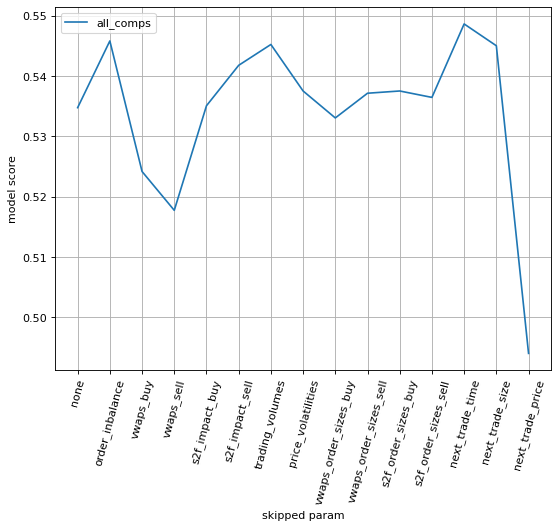

In [89]:
figure(figsize=(8, 6), dpi=80)

plt.axes(xlabel='skipped param', ylabel='model score')
plt.xticks(np.arange(len(skipped_params)), skipped_params, rotation='75')
plt.grid()
#for c in range(len(comps)):
 #   plt.plot( scores[c])
plt.plot(np.sum(scores, axis=0)/len(comps))
plt.legend(['all_comps'])
 ### DRZEWO

# find threshold for price swing

In [145]:
time_back=1
time_to_skip=30
split_percent = 0.8
interval=1
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
names=[   
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    'next_trade_price']
thresholds=np.geomspace(1e-3, 1e-10, num=8)
comp_ths=np.zeros((len(list_of_companies_number), len(thresholds)))

In [146]:
time_start=time.time()
for comp_id in range(len(list_of_companies_number)//10):
    print(comp_id)
    X=get_X(comp_id, interval, time_to_skip, time_back, names) 
    for th in range(len(thresholds)):
        print('threshold ', thresholds[th])
        print(X.shape)
        y=get_y(comp_id, interval, time_to_skip, time_back, y_name='true_price', 
                check='swing_max', swing_interval=60, threshold=thresholds[th])
        print(y.shape)
        comp_ths[comp_id,th]=logistic_regr(X, y,split_percent, check_up_down=False, track_params=False)
print("calculations took: {} seconds".format(  time.time()-time_start))

0
threshold  0.001
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   -2.226298905535126
vwaps_buy   -0.15847753515344531
vwaps_sell   1.6977765079299565
next_trade_price   1.9757033535081434
threshold  0.0001
(4790, 4)


<ipython-input-55-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price
<ipython-input-55-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   -2.5139739362839775
vwaps_buy   -0.5861448294007612
vwaps_sell   -1.051185834087683
next_trade_price   2.141575048709088
threshold  1e-05
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   -2.006338021781292
vwaps_buy   -0.7068133047728501
vwaps_sell   -0.8852388281409201
next_trade_price   1.6405205187251715
threshold  1e-06
(4790, 4)


<ipython-input-55-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price
<ipython-input-55-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   -2.027243043790667
vwaps_buy   -0.7102589147133257
vwaps_sell   -0.6434459304098908
next_trade_price   1.4038115500892785
threshold  1e-07
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   -1.735734185828877
vwaps_buy   -0.6410420910509359
vwaps_sell 

<ipython-input-55-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price
<ipython-input-55-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


  -0.7643065113423445
next_trade_price   1.6591198910027818
threshold  1e-08
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   -2.1717609587180227
vwaps_buy   -0.6029472254899169
vwaps_sell   -0.8656578458260205
next_trade_price   1.5567789331149513
threshold  1e-09
(4790, 4)


<ipython-input-55-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price
<ipython-input-55-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   -2.2854420002617153
vwaps_buy   -0.6575042317744016
vwaps_sell   -0.9155280349826399
next_trade_price   1.5688116982308893
threshold  1e-10
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   -1.8778733656421138
vwaps_buy   -0.5164609908069762
vwaps_sell   -0.4126176435519375
next_trade_price   1.4582432015635387
1
threshold  0.001
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   0.1347390897098006
vwaps_buy   0.8026456366011359
vwaps_sell   2.756805475187309
next_trade_price   0.46412745688943735
threshold  0.0001
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   0.2128182401346669
vwaps_buy   0.0413369436807777
vwaps_sell   1.2127780977409477
next_trade_price   1.0882146639134933
threshold  1e-05
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   0.0607587308717996
vwaps_buy   -0.31182692116773286
vwaps_sell   0.5646115988111013
next_trade_price   0.9179072044493711
threshold  1e-06
(4790, 4)
(4790,)
Coefficient impa

<ipython-input-55-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price
<ipython-input-55-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   0.9631094135478783
vwaps_buy   0.11050479442697383
vwaps_sell   -0.5045608500794748
next_trade_price   1.1594188185523149
threshold  1e-05
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   1.8288665535798718
vwaps_buy   -0.1196635978771736
vwaps_sell   -0.05811008979629902
next_trade_price   0.3997085754715057
threshold  1e-06
(4790, 4)


<ipython-input-55-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price
<ipython-input-55-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   2.1542906355354305
vwaps_buy   -0.8013907622376865
vwaps_sell   -0.9041386291759954
next_trade_price   1.1347757310586906
threshold  1e-07
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   2.4400212693248275
vwaps_buy   -0.7980266546537368
vwaps_sell   -0.9670617729141842
next_trade_price   1.2415484393315563
threshold  1e-08
(4790, 4)


<ipython-input-55-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price
<ipython-input-55-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   2.68987187139088
vwaps_buy   -0.6878358317129053
vwaps_sell   -1.2838651652405644
next_trade_price   1.521819492925112
threshold  1e-09
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   2.1830202261475153
vwaps_buy   -0.9964933142338884
vwaps_sell   -0.18670905866080617
next_trade_price   0.440226104432729
threshold  1e-10
(4790, 4)


<ipython-input-55-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price
<ipython-input-55-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   2.136681333211497
vwaps_buy   -0.9782927392717461
vwaps_sell   -0.07928474317328166
next_trade_price   0.309790736290058
4
threshold  0.001
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   1.2613686345666573
vwaps_buy   -1.1150571248842207
vwaps_sell   0.07642223160363652
next_trade_price   0.6497371833254981
threshold  0.0001
(4790, 4)


<ipython-input-55-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price
<ipython-input-55-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   0.4910401175879884
vwaps_buy   -1.2683740922205073
vwaps_sell   0.0541569007032167
next_trade_price   -0.3088205696889106
threshold  1e-05
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   0.1594054088465433
vwaps_buy   -1.4345357883950107
vwaps_sell   -0.08196123712556823
next_trade_price   -0.4855297977665809
threshold  1e-06
(4790, 4)


<ipython-input-55-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price
<ipython-input-55-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   -0.27003609574329035
vwaps_buy   -1.173782790524619
vwaps_sell   -0.06375090529418966
next_trade_price   -0.22568017981919206
threshold  1e-07
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   -0.10985110788835128
vwaps_buy   -1.2598237259822247
vwaps_sell   -0.05609390763984428
next_trade_price   -0.37229190333169354
threshold  1e-08
(4790, 4)


<ipython-input-55-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price
<ipython-input-55-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   -0.11034805950155514
vwaps_buy   -1.4181539483332741
vwaps_sell   -0.0538703502857378
next_trade_price   -0.46233963048460947
threshold  1e-09
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   0.2580088829582734
vwaps_buy   -1.4735617242036454
vwaps_sell   0.01971293390249313
next_trade_price   -0.6322592869993965
threshold  1e-10
(4790, 4)


<ipython-input-55-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price
<ipython-input-55-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   0.13726979929643854
vwaps_buy   -1.2426708978175574
vwaps_sell   -0.06102180770092669
next_trade_price   -0.3869606097613668
5
threshold  0.001
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   -0.16379604242467108
vwaps_buy   -0.18974778192429448
vwaps_sell   0.3274149265925394
next_trade_price   -0.08670520639453985
threshold  0.0001
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   -0.327337867073509
vwaps_buy   -0.9212771655189629
vwaps_sell   0.01589976027994265
next_trade_price   -0.13241501144558818
threshold  1e-05
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   -0.15910415337432224
vwaps_buy   -0.8020706981034298
vwaps_sell   -0.07435976761051842
next_trade_price   0.09649504136406577
threshold  1e-06
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   0.039160657501463844
vwaps_buy   -0.8298255341685236
vwaps_sell   -0.0978785083345924
next_trade_price   0.054294621252807075
threshold  1e-07
(4790, 4)
(4790

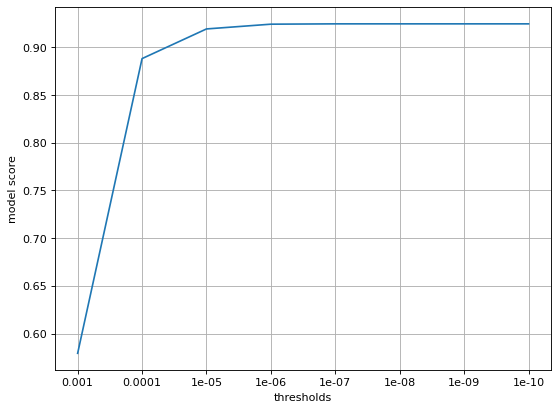

In [147]:
figure(figsize=(8, 6), dpi=80)
plt.axes(xlabel='thresholds', ylabel='model score')
plt.xticks(np.arange(len(thresholds)), thresholds, rotation='0')
plt.grid()

plt.plot(np.sum(comp_ths, axis=0)/9)

In [153]:
thresholds=np.arange(5*1e-4,5*1e-4+1e-3, step=1e-4)
comp_ths=np.zeros((len(list_of_companies_number), len(thresholds)))

In [265]:
np.arange(1e-4, 1e-3, step=1e-4)

array([0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008,
       0.0009])

In [171]:
time_start=time.time()
for comp_id in range(len(list_of_companies_number)):
    print(comp_id)
    X=get_X(comp_id, interval, time_to_skip, time_back, names) 
    for th in range(len(thresholds)):
        print('threshold ', thresholds[th])
        print(X.shape)
        y=get_y(comp_id, interval, time_to_skip, time_back, y_name='true_price', 
                check='swing_max', swing_interval=60, threshold=thresholds[th])
        print(y.shape)
        comp_ths[comp_id,th]=logistic_regr(X, y,split_percent, check_up_down=False, track_params=False)
print("calculations took: {} seconds".format(  time.time()-time_start))

0
threshold  0.0005
(4790, 4)
true price at index 9,479 was zero!
(4790,)
Coefficient impact:
order_inbalance   -2.165791686039555
vwaps_buy   -0.5615459180578501
vwaps_sell   0.47792717283148983
next_trade_price   2.0333236885143138
threshold  0.0006000000000000001
(4790, 4)
true price at index 9,479 was zero!
(4790,)
Coefficient impact:
order_inbalance   -1.6776150082388421
vwaps_buy   -0.913416913753926
vwaps_sell   1.0028190625270723
next_trade_price   2.132600327516973
threshold  0.0007000000000000001
(4790, 4)
true price at index 9,479 was zero!
(4790,)
Coefficient impact:
order_inbalance   -1.9631495657498959
vwaps_buy   -0.5663386827345311
vwaps_sell   1.281739938943878
next_trade_price   2.5106556137115192
threshold  0.0008000000000000001
(4790, 4)
true price at index 9,479 was zero!
(4790,)
Coefficient impact:
order_inbalance   -1.8990836140432692
vwaps_buy   0.1020127146539621
vwaps_sell   1.3326725322281732
next_trade_price   2.2893786791434105
threshold  0.0009000000000000

true price at index 9,477 was zero!
true price at index 9,478 was zero!
true price at index 9,479 was zero!
(4790,)
Coefficient impact:
order_inbalance   1.3777590030706717
vwaps_buy   -0.5502230455283496
vwaps_sell   -0.3105420976698716
next_trade_price   0.762483999511551
threshold  0.0012000000000000003
(4790, 4)
true price at index 9,477 was zero!
true price at index 9,478 was zero!
true price at index 9,479 was zero!
(4790,)
Coefficient impact:
order_inbalance   1.724861988841891
vwaps_buy   -0.1746651715263057
vwaps_sell   -0.48384659241539274
next_trade_price   1.1407893739124615
threshold  0.0013000000000000004
(4790, 4)
true price at index 9,477 was zero!
true price at index 9,478 was zero!
true price at index 9,479 was zero!
(4790,)
Coefficient impact:
order_inbalance   1.851032396526256
vwaps_buy   0.04992512509463728
vwaps_sell   -0.7834192446131193
next_trade_price   1.364545056761306
threshold  0.0014000000000000004
(4790, 4)
true price at index 9,477 was zero!
true price

(4790,)
Coefficient impact:
order_inbalance   0.17432331996335948
vwaps_buy   -1.230902366017718
vwaps_sell   1.6724667038754546
next_trade_price   3.670000426181037
threshold  0.0011000000000000003
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   0.30305500525697093
vwaps_buy   -1.1380477624570118
vwaps_sell   1.2473532889002026
next_trade_price   2.3541308574951705
threshold  0.0012000000000000003
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   0.0313181902757338
vwaps_buy   -1.3569716795489983
vwaps_sell   0.9383262123914222
next_trade_price   2.5046843523805924
threshold  0.0013000000000000004
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   -0.11174540729590861
vwaps_buy   -1.1912231313919441
vwaps_sell   1.0815338680926028
next_trade_price   2.280446685101684
threshold  0.0014000000000000004
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   -0.12143774278587915
vwaps_buy   -1.2004875788421399
vwaps_sell   1.65075162211927
next_trade_price   2.563195560

(4790,)
Coefficient impact:
order_inbalance   0.23083822774789428
vwaps_buy   0.031438147136557466
vwaps_sell   1.202656699782312
next_trade_price   0.8073014393756753
threshold  0.0011000000000000003
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   0.5094096099767936
vwaps_buy   -0.38631187725167077
vwaps_sell   1.44440957252875
next_trade_price   1.0474199014292653
threshold  0.0012000000000000003
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   0.014329776020577818
vwaps_buy   -0.5097723899241169
vwaps_sell   1.9568538626768428
next_trade_price   0.9414077800904873
threshold  0.0013000000000000004
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   0.28125506071166
vwaps_buy   -0.7411568222992719
vwaps_sell   1.6862389060967282
next_trade_price   0.9139737212473868
threshold  0.0014000000000000004
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   0.18363094010754885
vwaps_buy   -0.6837208898253615
vwaps_sell   1.4932685567906476
next_trade_price   0.900843912

(4790,)
Coefficient impact:
order_inbalance   -0.2179366177442215
vwaps_buy   -0.6429925172850242
vwaps_sell   -0.36283297816138016
next_trade_price   1.1044513362869424
threshold  0.0011000000000000003
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   0.3799249425806098
vwaps_buy   -0.5506713490353267
vwaps_sell   -0.27652739881784033
next_trade_price   1.1427784466286064
threshold  0.0012000000000000003
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   0.21454680266384407
vwaps_buy   -0.2754789755176719
vwaps_sell   -0.42939635420209066
next_trade_price   0.9838544706271862
threshold  0.0013000000000000004
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   0.08147077880119175
vwaps_buy   -0.280689800764185
vwaps_sell   -0.13335102097178886
next_trade_price   0.8017160847524646
threshold  0.0014000000000000004
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   0.29435615419495514
vwaps_buy   -0.25357372957763913
vwaps_sell   -0.1233075077635407
next_trade_price  

(4790,)
Coefficient impact:
order_inbalance   0.842108337659091
vwaps_buy   -0.9375700877206538
vwaps_sell   0.4816782153407959
next_trade_price   0.49981213372564964
threshold  0.0011000000000000003
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   1.0067399351136608
vwaps_buy   -0.9277670964071832
vwaps_sell   0.5117677397624819
next_trade_price   0.6650172188935195
threshold  0.0012000000000000003
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   1.0836630219468442
vwaps_buy   -0.8121581549146849
vwaps_sell   0.6023898927623028
next_trade_price   0.9201856726680967
threshold  0.0013000000000000004
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   1.163057355120303
vwaps_buy   -0.5891851727662086
vwaps_sell   0.6717708730223613
next_trade_price   0.7009731371702798
threshold  0.0014000000000000004
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   1.5492690166597831
vwaps_buy   -0.5669650242828383
vwaps_sell   0.711001253416907
next_trade_price   1.135111837713

(4790,)
Coefficient impact:
order_inbalance   -0.3667580089961826
vwaps_buy   0.5466961866572125
vwaps_sell   2.825818644193905
next_trade_price   0.841857903142543
threshold  0.0011000000000000003
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   -0.04506845312159724
vwaps_buy   0.49495133400022645
vwaps_sell   2.2851992682316467
next_trade_price   0.603842381024557
threshold  0.0012000000000000003
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   0.20710365686787324
vwaps_buy   0.7620238200728214
vwaps_sell   2.872645179872053
next_trade_price   0.09290687008515253
threshold  0.0013000000000000004
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   -0.2586699820546208
vwaps_buy   0.5654995396733721
vwaps_sell   3.373350278203411
next_trade_price   0.8104024152294897
threshold  0.0014000000000000004
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   0.008834016069726157
vwaps_buy   0.8001110231026124
vwaps_sell   1.5465030456651445
next_trade_price   0.31644905024

true price at index 9,478 was zero!
true price at index 9,479 was zero!
(4790,)
Coefficient impact:
order_inbalance   -0.30125306542275165
vwaps_buy   -0.03114716987596716
vwaps_sell   -0.22865661075990118
next_trade_price   1.4549497831282632
threshold  0.0010000000000000002
(4790, 4)
true price at index 9,478 was zero!
true price at index 9,479 was zero!
(4790,)
Coefficient impact:
order_inbalance   -0.6617999180179154
vwaps_buy   -0.07254094704128862
vwaps_sell   -0.29705369674616783
next_trade_price   1.447612802765474
threshold  0.0011000000000000003
(4790, 4)
true price at index 9,478 was zero!
true price at index 9,479 was zero!
(4790,)
Coefficient impact:
order_inbalance   -0.6874006601039183
vwaps_buy   0.012905762791670182
vwaps_sell   -0.2650862641927328
next_trade_price   1.0405117668025226
threshold  0.0012000000000000003
(4790, 4)
true price at index 9,478 was zero!
true price at index 9,479 was zero!
(4790,)
Coefficient impact:
order_inbalance   -0.671864710265382
vwaps_

threshold  0.0005
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   -0.6099478933123723
vwaps_buy   0.03850097051254616
vwaps_sell   0.6418401793002825
next_trade_price   0.42073878465878894
threshold  0.0006000000000000001
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   -0.8525156922533507
vwaps_buy   -0.476408290003249
vwaps_sell   0.3630901418773212
next_trade_price   0.7661950910203958
threshold  0.0007000000000000001
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   -0.3787810043468637
vwaps_buy   -0.2854417154198533
vwaps_sell   0.7412174092693615
next_trade_price   0.43197389149258725
threshold  0.0008000000000000001
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   -0.46794167299096473
vwaps_buy   0.059421228084785824
vwaps_sell   0.5574620675396187
next_trade_price   0.8772703376478946
threshold  0.0009000000000000002
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   -0.5767579840707632
vwaps_buy   -0.13243398878898596
vwaps_sell   0.17272107835

threshold  0.0014000000000000004
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   0.3254187624311649
vwaps_buy   0.2211900145636001
vwaps_sell   0.5275465946151962
next_trade_price   0.003608152418462147
34
threshold  0.0005
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   -0.040466086438299236
vwaps_buy   -0.1455408712494803
vwaps_sell   1.0250364689137366
next_trade_price   4.235458219812867
threshold  0.0006000000000000001
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   -0.5441256177565841
vwaps_buy   -0.0832642990722961
vwaps_sell   1.9495726877563484
next_trade_price   3.093908427858847
threshold  0.0007000000000000001
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   0.521896529200782
vwaps_buy   0.21970916681279512
vwaps_sell   1.4336023301120577
next_trade_price   3.338698709778516
threshold  0.0008000000000000001
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   0.16804015785437487
vwaps_buy   -0.16252271650598704
vwaps_sell   1.34623726930149

(4790,)
Coefficient impact:
order_inbalance   -2.076400225313882
vwaps_buy   -0.9862072293283026
vwaps_sell   1.3171548795440853
next_trade_price   2.2356058614587067
38
threshold  0.0005
(4790, 4)
true price at index 9,474 was zero!
true price at index 9,475 was zero!
true price at index 9,476 was zero!
true price at index 9,477 was zero!
true price at index 9,478 was zero!
true price at index 9,479 was zero!
(4790,)
Coefficient impact:
order_inbalance   1.8630744291647379
vwaps_buy   0.17767255001191926
vwaps_sell   -1.525724794900001
next_trade_price   1.3021024513763817
threshold  0.0006000000000000001
(4790, 4)
true price at index 9,474 was zero!
true price at index 9,475 was zero!
true price at index 9,476 was zero!
true price at index 9,477 was zero!
true price at index 9,478 was zero!
true price at index 9,479 was zero!
(4790,)
Coefficient impact:
order_inbalance   1.8305620600930186
vwaps_buy   0.2954234025390562
vwaps_sell   -1.6723198343418637
next_trade_price   1.1913197145

true price at index 9,479 was zero!
(4790,)
Coefficient impact:
order_inbalance   -0.13047173675349308
vwaps_buy   -0.1632187611613053
vwaps_sell   0.9014871635139945
next_trade_price   1.37396939957829
threshold  0.0011000000000000003
(4790, 4)
true price at index 9,479 was zero!
(4790,)
Coefficient impact:
order_inbalance   -0.014390440309068784
vwaps_buy   -0.24154596864011688
vwaps_sell   1.3352386972454566
next_trade_price   1.621712416798488
threshold  0.0012000000000000003
(4790, 4)
true price at index 9,479 was zero!
(4790,)
Coefficient impact:
order_inbalance   -0.08280215901764862
vwaps_buy   -0.550761982959306
vwaps_sell   1.255794143649881
next_trade_price   1.3594258889413144
threshold  0.0013000000000000004
(4790, 4)
true price at index 9,479 was zero!
(4790,)
Coefficient impact:
order_inbalance   0.12736927868791434
vwaps_buy   -0.7564831838396425
vwaps_sell   1.2087899618925333
next_trade_price   1.594865740119191
threshold  0.0014000000000000004
(4790, 4)
true price at

threshold  0.0005
(4790, 4)
true price at index 9,378 was zero!
true price at index 9,379 was zero!
true price at index 9,380 was zero!
true price at index 9,381 was zero!
true price at index 9,382 was zero!
true price at index 9,383 was zero!
true price at index 9,384 was zero!
true price at index 9,385 was zero!
true price at index 9,386 was zero!
true price at index 9,387 was zero!
true price at index 9,388 was zero!
true price at index 9,389 was zero!
true price at index 9,390 was zero!
true price at index 9,391 was zero!
true price at index 9,392 was zero!
true price at index 9,393 was zero!
true price at index 9,394 was zero!
true price at index 9,395 was zero!
true price at index 9,396 was zero!
true price at index 9,397 was zero!
true price at index 9,398 was zero!
true price at index 9,399 was zero!
true price at index 9,400 was zero!
true price at index 9,401 was zero!
true price at index 9,402 was zero!
true price at index 9,403 was zero!
true price at index 9,404 was zero!


threshold  0.0008000000000000001
(4790, 4)
true price at index 9,378 was zero!
true price at index 9,379 was zero!
true price at index 9,380 was zero!
true price at index 9,381 was zero!
true price at index 9,382 was zero!
true price at index 9,383 was zero!
true price at index 9,384 was zero!
true price at index 9,385 was zero!
true price at index 9,386 was zero!
true price at index 9,387 was zero!
true price at index 9,388 was zero!
true price at index 9,389 was zero!
true price at index 9,390 was zero!
true price at index 9,391 was zero!
true price at index 9,392 was zero!
true price at index 9,393 was zero!
true price at index 9,394 was zero!
true price at index 9,395 was zero!
true price at index 9,396 was zero!
true price at index 9,397 was zero!
true price at index 9,398 was zero!
true price at index 9,399 was zero!
true price at index 9,400 was zero!
true price at index 9,401 was zero!
true price at index 9,402 was zero!
true price at index 9,403 was zero!
true price at index 9

true price at index 9,378 was zero!
true price at index 9,379 was zero!
true price at index 9,380 was zero!
true price at index 9,381 was zero!
true price at index 9,382 was zero!
true price at index 9,383 was zero!
true price at index 9,384 was zero!
true price at index 9,385 was zero!
true price at index 9,386 was zero!
true price at index 9,387 was zero!
true price at index 9,388 was zero!
true price at index 9,389 was zero!
true price at index 9,390 was zero!
true price at index 9,391 was zero!
true price at index 9,392 was zero!
true price at index 9,393 was zero!
true price at index 9,394 was zero!
true price at index 9,395 was zero!
true price at index 9,396 was zero!
true price at index 9,397 was zero!
true price at index 9,398 was zero!
true price at index 9,399 was zero!
true price at index 9,400 was zero!
true price at index 9,401 was zero!
true price at index 9,402 was zero!
true price at index 9,403 was zero!
true price at index 9,404 was zero!
true price at index 9,405 wa

threshold  0.0005
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   -0.48802311018087985
vwaps_buy   -1.270988323413144
vwaps_sell   0.5305230976435592
next_trade_price   1.058349430612313
threshold  0.0006000000000000001
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   -0.29743765355747565
vwaps_buy   -1.2627209849884415
vwaps_sell   1.515298313515287
next_trade_price   0.6700277604416672
threshold  0.0007000000000000001
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   -0.8381787422512965
vwaps_buy   -0.6617927316870161
vwaps_sell   0.8611377030918688
next_trade_price   1.2003158384852965
threshold  0.0008000000000000001
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   -1.1586377120737017
vwaps_buy   -0.8371619200502323
vwaps_sell   0.33272998472605414
next_trade_price   1.1095507165249248
threshold  0.0009000000000000002
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   -1.0190816051251632
vwaps_buy   -0.6937580852429391
vwaps_sell   0.688526922232212

(4790,)
Coefficient impact:
order_inbalance   -2.0013252875014205
vwaps_buy   -0.07660304291310857
vwaps_sell   1.5192432226826287
next_trade_price   -0.24504635158006152
49
threshold  0.0005
(4790, 4)
true price at index 9,478 was zero!
true price at index 9,479 was zero!
(4790,)
Coefficient impact:
order_inbalance   -0.8825596358520045
vwaps_buy   -1.0640218613371206
vwaps_sell   -0.3580668820003081
next_trade_price   0.3781674699784909
threshold  0.0006000000000000001
(4790, 4)
true price at index 9,478 was zero!
true price at index 9,479 was zero!
(4790,)
Coefficient impact:
order_inbalance   -1.3081623246538763
vwaps_buy   -0.5756632516330541
vwaps_sell   -0.05619700500455335
next_trade_price   -0.182241274750155
threshold  0.0007000000000000001
(4790, 4)
true price at index 9,478 was zero!
true price at index 9,479 was zero!
(4790,)
Coefficient impact:
order_inbalance   -0.6666111355439354
vwaps_buy   -1.0994938574140567
vwaps_sell   -0.1533534737257492
next_trade_price   -0.1297

(4790,)
Coefficient impact:
order_inbalance   0.5465496631558796
vwaps_buy   -0.09074571946773319
vwaps_sell   -0.0034666715267513797
next_trade_price   1.0792110074029975
threshold  0.0009000000000000002
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   0.5406659267807694
vwaps_buy   -0.5410500012110956
vwaps_sell   -0.20585352235546805
next_trade_price   1.4228272311999581
threshold  0.0010000000000000002
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   0.839795318751817
vwaps_buy   -0.5969287792080089
vwaps_sell   0.17459626233978234
next_trade_price   0.9047894650858239
threshold  0.0011000000000000003
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   0.9533951256886488
vwaps_buy   -0.8972231667610716
vwaps_sell   0.31132772598172054
next_trade_price   1.1046919037241234
threshold  0.0012000000000000003
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   0.54034818334927
vwaps_buy   -0.3695534642280606
vwaps_sell   0.2802167930302589
next_trade_price   1.1235

(4790,)
Coefficient impact:
order_inbalance   0.7746860510777578
vwaps_buy   -0.5739227097771701
vwaps_sell   2.449492510074048
next_trade_price   0.2654729377068523
threshold  0.0009000000000000002
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   0.09056135781736632
vwaps_buy   -0.32516794629485174
vwaps_sell   2.390506143490889
next_trade_price   0.33535469426817893
threshold  0.0010000000000000002
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   0.21947825564332188
vwaps_buy   -0.08591695345111647
vwaps_sell   2.4998850603471845
next_trade_price   0.5883104845381311
threshold  0.0011000000000000003
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   0.7831737329370002
vwaps_buy   -0.19620975162386428
vwaps_sell   2.513518842396024
next_trade_price   0.4108293331844042
threshold  0.0012000000000000003
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   0.741668356219672
vwaps_buy   -0.46098352021348576
vwaps_sell   2.728360576996433
next_trade_price   0.68625564

(4790,)
Coefficient impact:
order_inbalance   0.3208934382452909
vwaps_buy   0.47944524007164235
vwaps_sell   0.670263722141676
next_trade_price   0.13866231550631106
threshold  0.0008000000000000001
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   0.16336083347365726
vwaps_buy   0.5289993322693612
vwaps_sell   0.6347689382866262
next_trade_price   0.10759739764561482
threshold  0.0009000000000000002
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   0.2470006313185562
vwaps_buy   0.5160881153476746
vwaps_sell   0.3910793438602376
next_trade_price   0.29706078975402855
threshold  0.0010000000000000002
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   0.7451062271116922
vwaps_buy   0.8185345655012174
vwaps_sell   0.298625331929372
next_trade_price   0.2711058145471015
threshold  0.0011000000000000003
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   0.3608484031764747
vwaps_buy   1.1110376627683163
vwaps_sell   0.3682484267523463
next_trade_price   0.331774449004

(4790,)
Coefficient impact:
order_inbalance   -0.4436820639013598
vwaps_buy   0.06518161379674445
vwaps_sell   -0.4871737007490424
next_trade_price   -1.011927893130463
threshold  0.0009000000000000002
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   -0.3251333836939886
vwaps_buy   0.5417150130807009
vwaps_sell   -0.17177033377742976
next_trade_price   -0.8511180244698546
threshold  0.0010000000000000002
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   -0.02429342433485095
vwaps_buy   0.3617218707596558
vwaps_sell   -0.1714615050527051
next_trade_price   -0.7916031005947832
threshold  0.0011000000000000003
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   -0.25371864656296456
vwaps_buy   0.4836382617586806
vwaps_sell   0.07159733663496126
next_trade_price   -1.3257379678871337
threshold  0.0012000000000000003
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   -0.23660853123177056
vwaps_buy   0.45213518170123673
vwaps_sell   0.12261624028990507
next_trade_price 

(4790,)
Coefficient impact:
order_inbalance   1.8628831429060622
vwaps_buy   1.1490866866667362
vwaps_sell   1.662709285018093
next_trade_price   0.6699232797425797
threshold  0.0009000000000000002
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   2.130821553351295
vwaps_buy   0.9848953533544144
vwaps_sell   1.8436019765339104
next_trade_price   0.46605006690518436
threshold  0.0010000000000000002
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   2.4885718018163296
vwaps_buy   0.827248168552529
vwaps_sell   1.9726269282446813
next_trade_price   0.2876785388202894
threshold  0.0011000000000000003
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   1.976664495372993
vwaps_buy   0.9658675278685075
vwaps_sell   1.4440301595251452
next_trade_price   0.2039681614639874
threshold  0.0012000000000000003
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   1.9506617220888793
vwaps_buy   1.0645917903451125
vwaps_sell   1.2155456830353344
next_trade_price   0.2975494566522744
t

(4790,)
Coefficient impact:
order_inbalance   -0.36959631352933914
vwaps_buy   0.06767014412646026
vwaps_sell   1.8242617519908844
next_trade_price   2.0765362232658506
threshold  0.0008000000000000001
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   0.27894702815342126
vwaps_buy   -0.1959445635514687
vwaps_sell   1.914949710445991
next_trade_price   1.6101848663414358
threshold  0.0009000000000000002
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   0.3910446928548794
vwaps_buy   -0.06303936686636136
vwaps_sell   1.7698512917228024
next_trade_price   1.3948538356802285
threshold  0.0010000000000000002
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   -0.3591030763959629
vwaps_buy   0.047311032055248954
vwaps_sell   1.1812966069939341
next_trade_price   1.5577116513426361
threshold  0.0011000000000000003
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   0.039891356182017265
vwaps_buy   0.026738767792982256
vwaps_sell   1.0825684096541321
next_trade_price   1.30

(4790,)
Coefficient impact:
order_inbalance   -0.14156711786995138
vwaps_buy   -0.6688353582191384
vwaps_sell   2.2464000982745014
next_trade_price   3.6154519850798224
threshold  0.0007000000000000001
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   0.9466556660368843
vwaps_buy   -1.2357684544136185
vwaps_sell   1.9227401716044432
next_trade_price   3.6147064087425167
threshold  0.0008000000000000001
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   0.7415961052025309
vwaps_buy   -0.7158016353351541
vwaps_sell   2.153887037183183
next_trade_price   3.018874421467227
threshold  0.0009000000000000002
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   -0.2256656868085273
vwaps_buy   -0.003948375564676228
vwaps_sell   1.9286333432378238
next_trade_price   3.3249026738757927
threshold  0.0010000000000000002
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   0.3473735752462273
vwaps_buy   -0.7104689276773759
vwaps_sell   1.3938072271707753
next_trade_price   2.9427789

true price at index 9,477 was zero!
true price at index 9,478 was zero!
true price at index 9,479 was zero!
(4790,)
Coefficient impact:
order_inbalance   0.9195639263756575
vwaps_buy   -1.3727814656071977
vwaps_sell   1.5770187691488526
next_trade_price   2.2087591989470043
threshold  0.0013000000000000004
(4790, 4)
true price at index 9,477 was zero!
true price at index 9,478 was zero!
true price at index 9,479 was zero!
(4790,)
Coefficient impact:
order_inbalance   1.2685492314152071
vwaps_buy   -1.741906279318981
vwaps_sell   1.668489729571775
next_trade_price   2.0371206153236185
threshold  0.0014000000000000004
(4790, 4)
true price at index 9,477 was zero!
true price at index 9,478 was zero!
true price at index 9,479 was zero!
(4790,)
Coefficient impact:
order_inbalance   0.8555434528457748
vwaps_buy   -1.2830777034455598
vwaps_sell   1.4365363246727734
next_trade_price   1.9709280656199235
80
threshold  0.0005
(4790, 4)
true price at index 9,479 was zero!
(4790,)
Coefficient impa

vwaps_sell   -0.757577306879774
next_trade_price   1.8059593117456503
threshold  0.0014000000000000004
(4790, 4)
true price at index 9,476 was zero!
true price at index 9,477 was zero!
true price at index 9,478 was zero!
true price at index 9,479 was zero!
(4790,)
Coefficient impact:
order_inbalance   -1.7623254046011658
vwaps_buy   0.11017395291090595
vwaps_sell   -1.895628303571714
next_trade_price   3.1319727222606586
83
threshold  0.0005
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   1.0679847296321874
vwaps_buy   -0.5663875334158391
vwaps_sell   1.136954700835481
next_trade_price   1.1568379135551616
threshold  0.0006000000000000001
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   0.6857301550593562
vwaps_buy   -0.3290161043066597
vwaps_sell   1.5301200017074488
next_trade_price   1.6398849964181101
threshold  0.0007000000000000001
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   0.8198647433139281
vwaps_buy   -0.4662273225562403
vwaps_sell   1.8712044762116

(4790,)
Coefficient impact:
order_inbalance   1.6279897493804862
vwaps_buy   0.07484003506218313
vwaps_sell   -0.10230275773098131
next_trade_price   1.8922244601784408
threshold  0.0011000000000000003
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   1.6916481303639173
vwaps_buy   -0.6881343073304933
vwaps_sell   -0.33904676120995003
next_trade_price   1.6992928852725857
threshold  0.0012000000000000003
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   0.7297700341565158
vwaps_buy   -0.7081507394398793
vwaps_sell   -0.08933436620330976
next_trade_price   0.939352539023511
threshold  0.0013000000000000004
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   1.2943731809759988
vwaps_buy   -0.42327486680664017
vwaps_sell   -0.34837176073960385
next_trade_price   0.8737099821345944
threshold  0.0014000000000000004
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   1.4491686190908473
vwaps_buy   -0.2772119619716476
vwaps_sell   -0.32292246237840544
next_trade_price   0.

(4790,)
Coefficient impact:
order_inbalance   2.3506688688157253
vwaps_buy   -1.293015409328725
vwaps_sell   0.682981117908504
next_trade_price   3.27532870562716
threshold  0.0009000000000000002
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   1.9215844381165545
vwaps_buy   -2.0038615894460383
vwaps_sell   0.8460256988087697
next_trade_price   3.6576183844810943
threshold  0.0010000000000000002
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   2.035455963089222
vwaps_buy   -2.247409652218801
vwaps_sell   0.39715526575433013
next_trade_price   3.501604247384466
threshold  0.0011000000000000003
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   2.0271194411293183
vwaps_buy   -2.176537987120597
vwaps_sell   0.7966004539962879
next_trade_price   2.890182066996649
threshold  0.0012000000000000003
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   2.222887761943292
vwaps_buy   -1.9014242668845383
vwaps_sell   0.49824369569690313
next_trade_price   2.8206227863930895
t

true price at index 9,479 was zero!
(4790,)
Coefficient impact:
order_inbalance   0.34199208495271693
vwaps_buy   -0.9667914672380328
vwaps_sell   1.1902312788169533
next_trade_price   1.449146887222972
threshold  0.0009000000000000002
(4790, 4)
true price at index 9,479 was zero!
(4790,)
Coefficient impact:
order_inbalance   0.5576148398697501
vwaps_buy   -0.7712490135040809
vwaps_sell   0.8066070618342325
next_trade_price   1.7701294368030018
threshold  0.0010000000000000002
(4790, 4)
true price at index 9,479 was zero!
(4790,)
Coefficient impact:
order_inbalance   0.5199332730258717
vwaps_buy   -1.0648867554612393
vwaps_sell   1.4206551929026268
next_trade_price   1.3509584923638152
threshold  0.0011000000000000003
(4790, 4)
true price at index 9,479 was zero!
(4790,)
Coefficient impact:
order_inbalance   0.2756012585401037
vwaps_buy   -1.2581229428927607
vwaps_sell   1.3426376021580286
next_trade_price   1.4533810443967181
threshold  0.0012000000000000003
(4790, 4)
true price at in

(4790,)
Coefficient impact:
order_inbalance   -0.0737097190167633
vwaps_buy   -0.8744201822346029
vwaps_sell   1.2089586733590088
next_trade_price   1.0926382637174252
threshold  0.0007000000000000001
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   -0.4214198720855664
vwaps_buy   -0.6598691227805188
vwaps_sell   1.6805708515196274
next_trade_price   0.8958866453579429
threshold  0.0008000000000000001
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   -0.22625219874740934
vwaps_buy   -1.1007618884537729
vwaps_sell   1.8052622716303384
next_trade_price   0.724994706960477
threshold  0.0009000000000000002
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   -0.29711475415036254
vwaps_buy   -0.5824915932480607
vwaps_sell   1.6593767258790852
next_trade_price   1.0297302373327635
threshold  0.0010000000000000002
(4790, 4)
(4790,)
Coefficient impact:
order_inbalance   -0.4275857333486003
vwaps_buy   -1.4745869663052638
vwaps_sell   2.030168479039378
next_trade_price   1.21540

In [167]:
get_true_price_comp(comp_id=0, interval=1)[9,509]

0.0

In [169]:
data[0,5098]

array([[[ 1075.,  1074.,  1073.,  1072.,  1071.],
        [16120., 13476., 22883., 15638., 11818.]],

       [[ 1076.,  1077.,  1078.,  1079.,  1080.],
        [ 2203., 20265., 19416., 16736., 16033.]]])

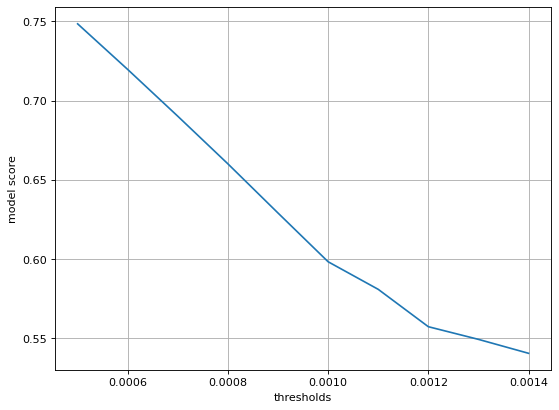

In [172]:
figure(figsize=(8, 6), dpi=80)
plt.axes(xlabel='thresholds', ylabel='model score')
#plt.xticks(np.arange(len(thresholds)), thresholds, rotation='90')
plt.grid()

plt.plot(thresholds,np.sum(comp_ths, axis=0)/99)

In [45]:
import torch

In [151]:
import tensorflow as tf
